---
# Models Performance Assesment 
---

In [54]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import pickle

from Equations_Run_Combo_V_2 import *
from Results_Dists_V_2 import *

import pickle

with open('/Users/cs/Desktop/LSTM_ETF/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

with open("/Users/cs/Desktop/LSTM_ETF/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)


#/home/charifslmn/

In [ ]:
#                                                       DATA SETS




#### Dist Disc data
with open('/Users/cs/Desktop/DATA_LSTM_ETF_V1/top_70_DIST_DISC_GS_21_01_to_22_12_chunk_1_32_10percentPOS_Vset_HOD.json') as f_json:
    results_dist_disc = json.load(f_json)   

    


###### T set with same seed sas val set, neeed sot be organized first 

with open('/Users/cs/Desktop/DATA_LSTM_ETF_V1/Tset_NOTsorted_same_seeds_70_models_GS_23_01_to_23_12_DIST_Discovery_10percentPOS_HOD.json') as f:
    results_dist_disc_Tset_NOTsorted_same_seeds = json.load(f)


# ignore = ['val_start_month', 'val_end_month' , 'seed']


##### Organizing the results to have same seeds and combos together --- since params were extracted themselves for GC run simplification 
results_dist_disc_Tset_same_seeds = copy.deepcopy(results_dist_disc_Tset_NOTsorted_same_seeds)

ignore_find_combo = ['val_start_month', 'val_end_month'  ]
### first collect combo_idxs and combo outer info
results_dist_disc_Tset_same_seeds_organized = []
for true in results_dist_disc: ### make sure the combo idx lines up, parallel_backend runs could vary since its the idx when func is called in parallel 
    t_cb_idx = true["combo_index"]

    # same_seed_and_combo = []
    dict_entry = {}
    tt = str({k: v for k, v in true['combo'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:

        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_combo}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')
        if tt == ff:
            dict_entry["combo_index"] = t_cb_idx
            dict_entry["combo"] = find["parameters"]
            results_dist_disc_Tset_same_seeds_organized.append(dict_entry)
            break
        

ignore_find_seeds = ['val_start_month', 'val_end_month'  , 'seed_num'   ]

### then collect per seed results for each combo , combos are
for entry in results_dist_disc_Tset_same_seeds_organized:
    entry["per_seed_all_results"] = []

    ee = str({k: v for k, v in entry['combo'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

    for find in results_dist_disc_Tset_same_seeds:
        ff = str({k: v for k, v in find['parameters'].items() if k not in ignore_find_seeds}).replace(' ', '').replace("'", '').replace('  ', '').replace(',', '')

        if ee == ff:
            seed_entry = {}
            # print(find["parameters"]["seed_num"])
            seed_entry["seed"] = find["parameters"]["seed_num"]
            seed_entry["result_entry"] = find
            entry["per_seed_all_results"].append(seed_entry)

##### Organizing the results to have same seeds and combos together

            


In [56]:

####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


Mp_H__param_map = {   # params to analyze
                             "mean_precision_range" : (75, 100),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None                                  
                               }

Mp_M__param_map = {   
                             "mean_precision_range" : (40, 75),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

Mp_L__param_map = {   
                             "mean_precision_range" : (5, 40),
                             "max_zero_precision_seeds" : 70,
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

#############

DES_Mp_ALL__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_ALL__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_ALL__Rfps_H__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
DES_Mp_ALL__R_L__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_ALL__R_H__param_map = {  
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : .3, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_ALL__R_neg__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################



Mp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__param_map)
Mp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_M__param_map)
Mp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_L__param_map)


DES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_H__param_map)
DES_Mp_ALL__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_L__param_map)
unDES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__Rfps_H__param_map)


DES_Mp_ALL__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_L__param_map)
DES_Mp_ALL__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_H__param_map)
unDES_Mp_ALL__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 
    "DES_Mp_H": Mp_H__param_map_models,
    "DES_Mp_M": Mp_M__param_map_models,
    "DES_Mp_L": Mp_L__param_map_models,

    "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__param_map_models,
    "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__param_map_models,
    "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__param_map_models,

    "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__param_map_models,
    "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__param_map_models,
    "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



#### collect raw V and T set data for the selected models
Mp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Mp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_ALL__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_Mp_ALL__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_ALL__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_ALL__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
#### collect raw V and T set data for the selected models

model_based_selection_maps_raw_V_T_data = {
    "Mp_H": Mp_H__data_V_T_rawData,
    "Mp_M": Mp_M__data_V_T_rawData,
    "Mp_L": Mp_L__data_V_T_rawData,

    "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__data_V_T_rawData,
    "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__data_V_T_rawData,
    "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__data_V_T_rawData,

    "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__data_V_T_rawData,
    "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__data_V_T_rawData,
    "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__data_V_T_rawData
}




Models Selected DES_Mp_H: 5
Total seeds selected DES_Mp_H: 337
-----
Models Selected DES_Mp_M: 26
Total seeds selected DES_Mp_M: 1644
-----
Models Selected DES_Mp_L: 39
Total seeds selected DES_Mp_L: 2541
-----
Models Selected DES_Mp_ALL__Rfps_H: 33
Total seeds selected DES_Mp_ALL__Rfps_H: 2230
-----
Models Selected DES_Mp_ALL__Rfps_L: 16
Total seeds selected DES_Mp_ALL__Rfps_L: 206
-----
Models Selected unDES_Mp_ALL__Rfps_H: 19
Total seeds selected unDES_Mp_ALL__Rfps_H: 1155
-----
Models Selected DES_Mp_ALL__R_L: 13
Total seeds selected DES_Mp_ALL__R_L: 825
-----
Models Selected DES_Mp_ALL__R_H: 3
Total seeds selected DES_Mp_ALL__R_H: 166
-----
Models Selected unDES_Mp_ALL__R_neg: 23
Total seeds selected unDES_Mp_ALL__R_neg: 1517
-----


In [57]:
####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Sp_H__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Sp_M__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Sp_L__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

DES_TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

DES_TH_Sp_ALL__Hb_1fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 1 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 3 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                            "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

####                                   Model Selection (SEED + MODEL Fileter)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : .25,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : .1, 
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (50, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , 
                             "min_seed_TPs_high_bracket" : 1 ,

                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),


                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_H__param_map)
Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_M__param_map)
Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_L__param_map)

DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_0fp1tp__param_map)
DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_1fp1tp__param_map)
DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


models_res_names_dict = {
    "Sp_H": Sp_H__param_map_models,
    "Sp_M": Sp_M__param_map_models,
    "Sp_L": Sp_L__param_map_models,


    "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


#### collect raw V and T set data for the selected models
Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
#### collect raw V and T set data for the selected models

model_AND_seed_based_selection_maps_raw_V_T_data = {
    "Sp_H": Sp_H__data_V_T_rawData,
    "Sp_M": Sp_M__data_V_T_rawData,   
    "Sp_L": Sp_L__data_V_T_rawData,

    "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,
    "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData,
    "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData,

    "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
}




Models Selected Sp_H: 67
Total seeds selected Sp_H: 757
-----
Models Selected Sp_M: 68
Total seeds selected Sp_M: 1431
-----
Models Selected Sp_L: 65
Total seeds selected Sp_L: 1547
-----
Models Selected DES_TH_Sp_ALL__Hb_0fp1tp: 57
Total seeds selected DES_TH_Sp_ALL__Hb_0fp1tp: 1196
-----
Models Selected DES_TH_Sp_ALL__Hb_1fp1tp: 58
Total seeds selected DES_TH_Sp_ALL__Hb_1fp1tp: 1733
-----
Models Selected DES_TH_Sp_ALL__Hb_tp_minus_fp: 39
Total seeds selected DES_TH_Sp_ALL__Hb_tp_minus_fp: 137
-----
Models Selected DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 3
Total seeds selected DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 88
-----


In [58]:
# dict_keys(['Mp_H', 'Mp_M', 'Mp_L', 'DES_Mp_ALL__Rfps_H', 'DES_Mp_ALL__Rfps_L', 'unDES_Mp_ALL__Rfps_H', 
#       'DES_Mp_ALL__R_L', 'DES_Mp_ALL__R_H', 'unDES_Mp_ALL__R_neg'])
models_data_V_T = {
    "Mp_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["T_set_data"]} ,
    "Mp_M" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["T_set_data"]} ,
    "Mp_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["T_set_data"]} ,
    ###
    "DES_Mp_ALL__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_H"]["T_set_data"]} ,
    "DES_Mp_ALL__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_L"]["T_set_data"]} ,
    "unDES_Mp_ALL__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H"]["T_set_data"]} ,
    ###
    "DES_Mp_ALL__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_L"]["T_set_data"]} ,
    "DES_Mp_ALL__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_H"]["T_set_data"]} ,
    "unDES_Mp_ALL__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["T_set_data"]}
}



# dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'DES_TH_Sp_ALL__Hb_0fp1tp', 'DES_TH_Sp_ALL__Hb_1fp1tp', 
#       'DES_TH_Sp_ALL__Hb_tp_minus_fp', 'DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
models_AND_seeds_data_V_T = {
    "Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["T_set_data"]} ,
    "Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["T_set_data"]} ,
    "Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["T_set_data"]} ,
    ###
    "DES_TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,
    "DES_TH_Sp_ALL__Hb_1fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_1fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_1fp1tp"]["T_set_data"]} ,
    "DES_TH_Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]} ,
    ###
    "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
}


In [59]:
#####       PURPOSE - THIS IS JSUT FOR TESTING 

def process_and_RETURN_analytics(V_set , T_set , 
                                 
                                 threshold = 0.7, 
                                 min_diff_params = 2,
                                 min_same_up_preds = 0 ,
                                 max_same_up_preds = 1 ,
                                 no_maps_per_group = 7 ,
                                 do_print = True):

    names_all = { 'res_mac_H_val': V_set, 
                'res_mac_H_test': T_set}

    # Define your groups configuration
    groups_config = [
        ("mac",  (-1, 1), 2),
        # ("mac",  (0.1, 0.2), 2),
        # ("mac",  (0.3, 0.5), 2),
        # ("mac",  (-1, 0.3), 3),
        # ("mac",  (0.1, 0.3), 3),
        # ("mac",  (0.3, 0.5), 3)
    ]

    number_realizations = 20

    all_results_regular = []
    all_results_threshold = []

    # random_seeds_seed = 4
    # random.seed(random_seeds_seed)

    sample_size = number_realizations
    seeds = random.sample(range(1, 100000), sample_size)

    for i, seed in zip(range(1, number_realizations), seeds):

        results = process_func_PLUS_return_analytics_THRESH_var_included (
                                            ## new params
                                        threshold = threshold,
                                        names_all = names_all,

                                        #new arams

                                        groups_config = groups_config,
                                        data_type_corr_groups_creation = "V",
                                        data_type_ensemble = "T",
                                        use_threshold_data = False,
                                        seed = None,
                                        no_maps_per_group = no_maps_per_group,
                                        filter_outliers = False ,#### NOTICE NOTICE
                                        use_corr_with_diff_params = False,

                                        min_diff_params = min_diff_params , 
                                        use_spearman_corr = False,
                                        
                                        use_corr_with_same_up_preds = True,
                                        min_same_up_preds = min_same_up_preds,
                                        max_same_up_preds = max_same_up_preds ,


                                        )
        all_results_regular.append(results)


    for i , seed in zip(range(1, number_realizations), seeds):

        results = process_func_PLUS_return_analytics_THRESH_var_included (
                                            ## new params
                                        threshold = threshold,
                                        names_all = names_all,

                                        #new arams

                                        groups_config = groups_config,
                                        data_type_corr_groups_creation = "V",
                                        data_type_ensemble = "T",
                                        use_threshold_data = True,
                                        seed = None,
                                        no_maps_per_group = no_maps_per_group,
                                        filter_outliers = False, #### NOTICE NOTICE
                                        use_corr_with_diff_params = False,

                                        min_diff_params = min_diff_params, 
                                        use_spearman_corr = False,
                                        
                                        use_corr_with_same_up_preds = True,
                                        min_same_up_preds = min_same_up_preds,
                                        max_same_up_preds = max_same_up_preds,

                                        )

        all_results_threshold.append(results)

    all_groups_prec_up_regular = []
    all_groups_total_return_regular = []
    no_up_preds_per_group_regular = []
    all_realizations_unique_actuals_ups_regular = []



            # "Sum of HOD Actual Returns for Up Predictions": HOD_sum_actuals_ups,
            # "Sum of UCO Actual Returns for Up Predictions": UCO_sum_actuals_ups,
            # "Sum of HUC Actual Returns for Up Predictions": HUC_sum_actuals_ups,

    for seed_res in all_results_regular:
        #first set of plots 
        all_groups_total_return_regular.append(seed_res["summary"]["Sum of Actual Returns for Up Predictions"])
        all_groups_prec_up_regular.append(seed_res["summary"]['Prec Up'])
        no_up_preds_per_group_regular.append(seed_res["summary"]['Total Up Predictions'])
        all_realizations_unique_actuals_ups_regular.append(seed_res["summary"]['Unique Actual Returns for Up Predictions'])


    all_realizations_unique_actuals_ups_regular_UNIQUE = set([item for sublist in all_realizations_unique_actuals_ups_regular for item in sublist])
    all_realizations_unique_actuals_ups_regular_UNIQUE_SUM = sum(all_realizations_unique_actuals_ups_regular_UNIQUE)



    all_groups_prec_up_threshold = []
    all_groups_total_return_threshold = []
    no_up_preds_per_group_threshold = []
    all_realizations_unique_actuals_ups_threshold = []



    for seed_res in all_results_threshold:
        all_groups_total_return_threshold.append(seed_res["summary"]["Sum of Actual Returns for Up Predictions"])
        all_groups_prec_up_threshold.append(seed_res["summary"]['Prec Up'])
        no_up_preds_per_group_threshold.append(seed_res["summary"]['Total Up Predictions'])
        all_realizations_unique_actuals_ups_threshold.append(seed_res["summary"]['Unique Actual Returns for Up Predictions'])


    all_realizations_unique_actuals_ups_threshold_UNIQUE = set([item for sublist in all_realizations_unique_actuals_ups_threshold for item in sublist])
    all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM = sum(all_realizations_unique_actuals_ups_threshold_UNIQUE)


    import matplotlib.pyplot as plt

    # List of variable names and titles
    metrics = [
        
        (all_groups_total_return_regular, 'Sum of Actual Returns (Regular)', 'blue'),
        (all_groups_prec_up_regular, 'Precision Up (Regular)', 'blue'),
        (no_up_preds_per_group_regular, 'No Up Predictions (Regular)', 'blue'),

        (all_groups_total_return_threshold, 'Sum of Actual Returns (Threshold)', 'red'),
        (all_groups_prec_up_threshold, 'Precision Up (Threshold)', 'red'),
        (no_up_preds_per_group_threshold, 'No Up Predictions (Threshold)', 'red'),

    ]

    if do_print:
        plt.figure(figsize=(20, 19))

        for i, (var_name, title, color) in enumerate(metrics, 1):

            plt.subplot(6, 3, i)
            data = var_name  # Get the variable by name
            plt.hist(data, bins=15, alpha=0.7, label=title, color=color)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {title}')
            plt.legend()

        plt.tight_layout()
        plt.show()


    # print("ALL Realizations Regular Unique Actuals Ups:", all_realizations_unique_actuals_ups_regular_UNIQUE)
    # print("ALL Realizations Regular Unique Actuals Ups Sum:", all_realizations_unique_actuals_ups_regular_UNIQUE_SUM)
    # print("Total Unique Up Preds Regular:", len(all_realizations_unique_actuals_ups_regular_UNIQUE))

    # print("ALL Realizations Threshold Unique Actuals Ups:", all_realizations_unique_actuals_ups_threshold_UNIQUE)
    # print("ALL Realizations Threshold Unique Actuals Ups Sum:", all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM)
    # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))

    output = {
    "all_realizations_unique_actuals_ups_regular_UNIQUE": all_realizations_unique_actuals_ups_regular_UNIQUE,
    "all_realizations_unique_actuals_ups_regular_UNIQUE_SUM": all_realizations_unique_actuals_ups_regular_UNIQUE_SUM,
    "LEN_all_realizations_unique_actuals_ups_regular_UNIQUE": len(all_realizations_unique_actuals_ups_regular_UNIQUE),

    "all_realizations_unique_actuals_ups_threshold_UNIQUE": all_realizations_unique_actuals_ups_threshold_UNIQUE,
    "all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM": all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM,
    "LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE": len(all_realizations_unique_actuals_ups_threshold_UNIQUE)
}

    return output

[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

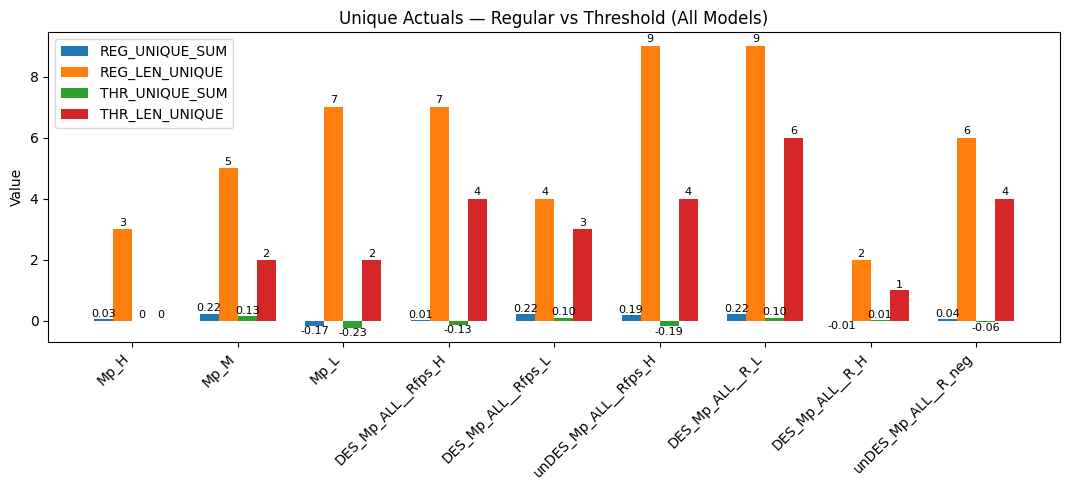

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Collect metrics for every model key
model_keys = list(models_data_V_T.keys())
metrics_per_model = []  # [REG_UNIQUE_SUM, REG_LEN_UNIQUE, THR_UNIQUE_SUM, THR_LEN_UNIQUE]

for k in model_keys:
    V_set = models_data_V_T[k]["V_set_data"]
    T_set = models_data_V_T[k]["T_set_data"]
    out = process_and_RETURN_analytics(V_set, T_set, do_print=False)

    metrics_per_model.append([
        out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"],
        out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"],
        out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"],
        out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"],
    ])

metrics = np.array(metrics_per_model, dtype=float)  # shape: (n_models, 4)

# 2) One grouped bar plot: many models on x-axis, 4 bars per model
labels = [
    "REG_UNIQUE_SUM",
    "REG_LEN_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_LEN_UNIQUE",
]

n_models = len(model_keys)
n_bars = len(labels)
x = np.arange(n_models, dtype=float)
width = 0.18
offsets = np.linspace(-(n_bars-1)/2*width, (n_bars-1)/2*width, n_bars)

fig, ax = plt.subplots(figsize=(max(8, n_models * 1.2), 5))

bars = []
for i in range(n_bars):
    b = ax.bar(x + offsets[i], metrics[:, i], width=width, label=labels[i])
    bars.append(b)

ax.set_xticks(x)
ax.set_xticklabels(model_keys, rotation=45, ha='right')
ax.set_ylabel("Value")
ax.set_title("Unique Actuals — Regular vs Threshold (All Models)")
ax.legend(loc="best")

# 3) Write values on the bars for clarity (different scales handled)
for b in bars:
    for rect in b:
        h = rect.get_height()
        x_pos = rect.get_x() + rect.get_width() / 2
        offset = 0.01 * (abs(h) if abs(h) > 1 else 1)
        y_pos = h + (offset if h >= 0 else -offset)
        va = "bottom" if h >= 0 else "top"
        txt = f"{int(h):,}" if float(h).is_integer() else f"{h:,.2f}"
        ax.text(x_pos, y_pos, txt, ha="center", va=va, fontsize=8)

fig.tight_layout()
plt.show()


[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

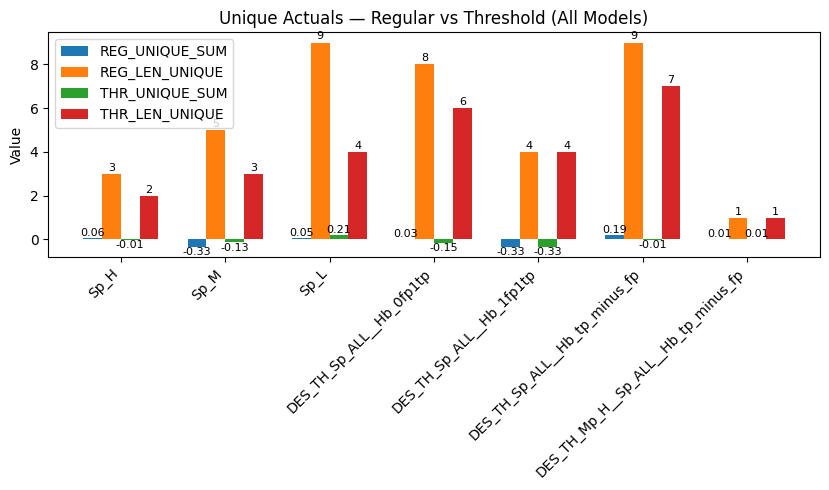

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Collect metrics for every model key
model_keys = list(models_AND_seeds_data_V_T.keys())
metrics_per_model = []  # [REG_UNIQUE_SUM, REG_LEN_UNIQUE, THR_UNIQUE_SUM, THR_LEN_UNIQUE]

for k in model_keys:
    V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
    T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
    out = process_and_RETURN_analytics(V_set, T_set, do_print=False)

    metrics_per_model.append([
        out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"],
        out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"],
        out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"],
        out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"],
    ])

metrics = np.array(metrics_per_model, dtype=float)  # shape: (n_models, 4)

# 2) One grouped bar plot: many models on x-axis, 4 bars per model
labels = [
    "REG_UNIQUE_SUM",
    "REG_LEN_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_LEN_UNIQUE",
]

n_models = len(model_keys)
n_bars = len(labels)
x = np.arange(n_models, dtype=float)
width = 0.18
offsets = np.linspace(-(n_bars-1)/2*width, (n_bars-1)/2*width, n_bars)

fig, ax = plt.subplots(figsize=(max(8, n_models * 1.2), 5))

bars = []
for i in range(n_bars):
    b = ax.bar(x + offsets[i], metrics[:, i], width=width, label=labels[i])
    bars.append(b)

ax.set_xticks(x)
ax.set_xticklabels(model_keys, rotation=45, ha='right')
ax.set_ylabel("Value")
ax.set_title("Unique Actuals — Regular vs Threshold (All Models)")
ax.legend(loc="best")

# 3) Write values on the bars for clarity (different scales handled)
for b in bars:
    for rect in b:
        h = rect.get_height()
        x_pos = rect.get_x() + rect.get_width() / 2
        offset = 0.01 * (abs(h) if abs(h) > 1 else 1)
        y_pos = h + (offset if h >= 0 else -offset)
        va = "bottom" if h >= 0 else "top"
        txt = f"{int(h):,}" if float(h).is_integer() else f"{h:,.2f}"
        ax.text(x_pos, y_pos, txt, ha="center", va=va, fontsize=8)

fig.tight_layout()
plt.show()


---
# Distibution of Preformances for Tested Params 

- plotting the distributions of the above results over multiple realization 
---

In [28]:
from Functions_1_Initial_GS_and_Dist_Analytics_HOD_20_01_21_12 import *
from Results_Dists_V_2 import *

In [29]:


### NOTE consider changing this os that the function chooses the max number of midels possible , this should imporve the resutls in general since 
### seeds of the same model are generally more correalted --- this can also be tested but i am pretty positive this is the case (ran short tests)

### NOTE for now since we want to test the params for model slection , it may be better to keep it as is for standardization

def collect_V_T_set_FULLraw_data(models_selected, results_dist_disc, results_dist_disc_Tset_same_seeds_organized):
    T_set_data = [] 
    V_set_data = []

    # select 5 models at random from the selected models
    models_RAND = random.sample(models_selected, min(10, len(models_selected)))

    for model_entry in models_RAND:
        model_seeds = []
        ff_combo_idx = model_entry['combo_index']
        for seed_entry in model_entry['selected_seeds']:
            seed_num = seed_entry['seed_num']
            model_seeds.append(seed_num)

        ##### Find randomly chosen seeds in the V and T raw data 
        for raw_data_entry_V in results_dist_disc:
            V_combo_idx = raw_data_entry_V["combo_index"]
            if ff_combo_idx == V_combo_idx:
                rand_chosen_seeds = random.sample(model_seeds, min(1, len(model_seeds)))
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_V['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            V_set_data.append(seed_raw['result_entry'])

        for raw_data_entry_T in results_dist_disc_Tset_same_seeds_organized:
            T_combo_idx = raw_data_entry_T["combo_index"]
            if ff_combo_idx == T_combo_idx:
                for seed_chosen in rand_chosen_seeds:
                    for seed_raw in raw_data_entry_T['per_seed_all_results']:
                        if seed_raw['seed'] == seed_chosen:
                            T_set_data.append(seed_raw['result_entry'])

    return {"V_set_data": V_set_data, "T_set_data": T_set_data}


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# res = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# V_set_data = res["V_set_data"] ; T_set_data = res["T_set_data"]
# print(len(V_set_data)) ; print(len(T_set_data))  


In [30]:

####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


Mp_H__param_map = {   # params to analyze
                             "mean_precision_range" : (75, 100),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None                                  
                               }

Mp_M__param_map = {   
                             "mean_precision_range" : (40, 75),
                             "max_zero_precision_seeds" : 70,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

Mp_L__param_map = {   
                             "mean_precision_range" : (5, 40),
                             "max_zero_precision_seeds" : 70,
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

#############

DES_Mp_ALL__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_ALL__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_ALL__Rfps_H__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
DES_Mp_ALL__R_L__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_ALL__R_H__param_map = {  
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : .3, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_ALL__R_neg__param_map = {   
                             "mean_precision_range" : (5, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################



# Mp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__param_map)
# Mp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_M__param_map)
# Mp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_L__param_map)


# DES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_H__param_map)
# DES_Mp_ALL__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_L__param_map)
# unDES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__Rfps_H__param_map)


# DES_Mp_ALL__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_L__param_map)
# DES_Mp_ALL__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_H__param_map)
# unDES_Mp_ALL__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__R_neg__param_map)


# # models_res_names_dict = { ## print model seleciton info , 
# #     "DES_Mp_H": Mp_H__param_map_models,
# #     "DES_Mp_M": Mp_M__param_map_models,
# #     "DES_Mp_L": Mp_L__param_map_models,

# #     "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__param_map_models,
# #     "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__param_map_models,
# #     "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__param_map_models,

# #     "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__param_map_models,
# #     "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__param_map_models,
# #     "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__param_map_models

# # }   

# # for k, selected_models in models_res_names_dict.items():
# #    print(f"Models Selected {k}: {len(selected_models)}")
# #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
# #    print(f"Total seeds selected {k}: {total_seeds}")
# #    print("-" * 5)



# #### collect raw V and T set data for the selected models
# Mp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# DES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# DES_Mp_ALL__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# unDES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# DES_Mp_ALL__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# DES_Mp_ALL__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# unDES_Mp_ALL__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
# #### collect raw V and T set data for the selected models

# model_based_selection_maps_raw_V_T_data = {
#     "Mp_H": Mp_H__data_V_T_rawData,
#     "Mp_M": Mp_M__data_V_T_rawData,
#     "Mp_L": Mp_L__data_V_T_rawData,

#     "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__data_V_T_rawData,
#     "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__data_V_T_rawData,
#     "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__data_V_T_rawData,

#     "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__data_V_T_rawData,
#     "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__data_V_T_rawData,
#     "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__data_V_T_rawData
# }

# import pickle
# with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
#     pickle.dump(model_based_selection_maps_raw_V_T_data, f)


In [31]:
####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Sp_H__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Sp_M__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Sp_L__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

DES_TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

DES_TH_Sp_ALL__Hb_1fp1tp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 1 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (5, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 3 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                            "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

####                                   Model Selection (SEED + MODEL Fileter)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None,
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (50, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 3 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),


                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


# Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_H__param_map)
# Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_M__param_map)
# Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_L__param_map)

# DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_0fp1tp__param_map)
# DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_1fp1tp__param_map)
# DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map)

# DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


# # models_res_names_dict = {
# #     "Sp_H": Sp_H__param_map_models,
# #     "Sp_M": Sp_M__param_map_models,
# #     "Sp_L": Sp_L__param_map_models,


# #     "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,
# #     "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models,
# #     "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

# #     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
# # }


# # for k , selected_models in models_res_names_dict.items():
# #    print(f"Models Selected {k}: {len(selected_models)}")
# #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
# #    print(f"Total seeds selected {k}: {total_seeds}")
# #    print("-" * 5)


# #### collect raw V and T set data for the selected models
# Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Sp_H__data_V_T_rawData,
#     "Sp_M": Sp_M__data_V_T_rawData,   
#     "Sp_L": Sp_L__data_V_T_rawData,

#     "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,
#     "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData,
#     "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData,

#     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


In [32]:

######################################                                                models selection code 

number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__param_map)
    Mp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_M__param_map)
    Mp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_L__param_map)


    DES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_H__param_map)
    DES_Mp_ALL__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__Rfps_L__param_map)
    unDES_Mp_ALL__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__Rfps_H__param_map)


    DES_Mp_ALL__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_L__param_map)
    DES_Mp_ALL__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_ALL__R_H__param_map)
    unDES_Mp_ALL__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_ALL__R_neg__param_map)


    # models_res_names_dict = { ## print model seleciton info , 
    #     "DES_Mp_H": Mp_H__param_map_models,
    #     "DES_Mp_M": Mp_M__param_map_models,
    #     "DES_Mp_L": Mp_L__param_map_models,

    #     "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__param_map_models,
    #     "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__param_map_models,
    #     "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__param_map_models,

    #     "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__param_map_models,
    #     "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__param_map_models,
    #     "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__param_map_models

    # }   

    # for k, selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_ALL__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_ALL__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_Mp_ALL__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_ALL__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_ALL__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_ALL__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_ALL__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {
        "Mp_H": Mp_H__data_V_T_rawData,
        "Mp_M": Mp_M__data_V_T_rawData,
        "Mp_L": Mp_L__data_V_T_rawData,

        "DES_Mp_ALL__Rfps_H": DES_Mp_ALL__Rfps_H__data_V_T_rawData,
        "DES_Mp_ALL__Rfps_L": DES_Mp_ALL__Rfps_L__data_V_T_rawData,
        "unDES_Mp_ALL__Rfps_H": unDES_Mp_ALL__Rfps_H__data_V_T_rawData,

        "DES_Mp_ALL__R_L": DES_Mp_ALL__R_L__data_V_T_rawData,
        "DES_Mp_ALL__R_H": DES_Mp_ALL__R_H__data_V_T_rawData,
        "unDES_Mp_ALL__R_neg": unDES_Mp_ALL__R_neg__data_V_T_rawData
    }


    # dict_keys(['Mp_H', 'Mp_M', 'Mp_L', 'DES_Mp_ALL__Rfps_H', 'DES_Mp_ALL__Rfps_L', 'unDES_Mp_ALL__Rfps_H', 
    #       'DES_Mp_ALL__R_L', 'DES_Mp_ALL__R_H', 'unDES_Mp_ALL__R_neg'])
    models_data_V_T = {
        "Mp_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_H"]["T_set_data"]} ,
        "Mp_M" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_M"]["T_set_data"]} ,
        "Mp_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["Mp_L"]["T_set_data"]} ,
        ###
        "DES_Mp_ALL__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_H"]["T_set_data"]} ,
        "DES_Mp_ALL__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__Rfps_L"]["T_set_data"]} ,
        "unDES_Mp_ALL__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__Rfps_H"]["T_set_data"]} ,
        ###
        "DES_Mp_ALL__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_L"]["T_set_data"]} ,
        "DES_Mp_ALL__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_ALL__R_H"]["T_set_data"]} ,
        "unDES_Mp_ALL__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_ALL__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))




[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

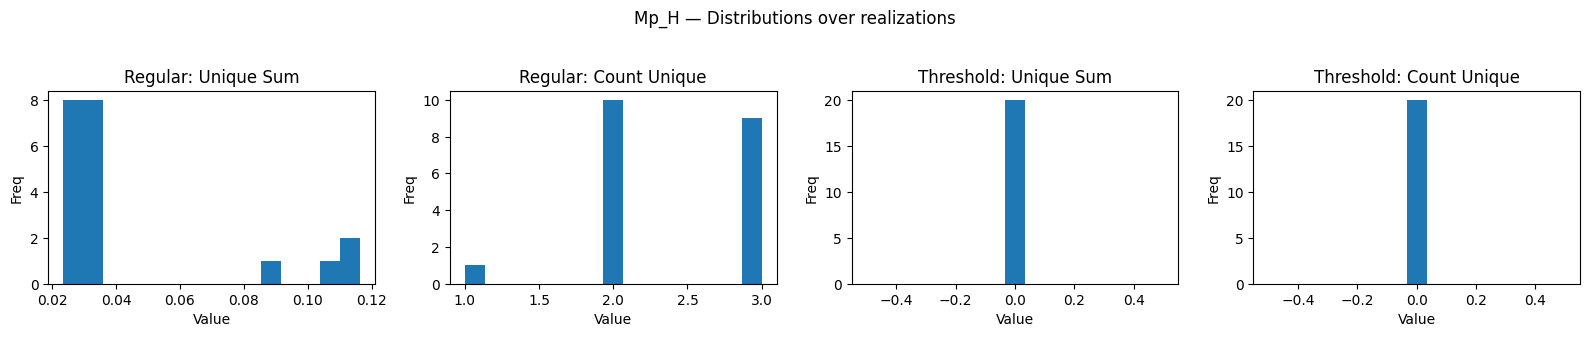

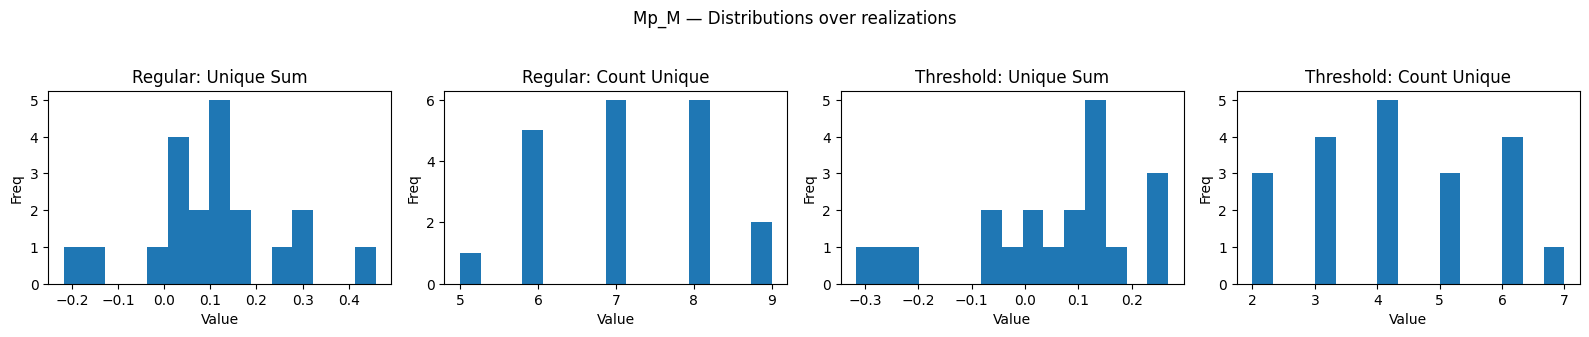

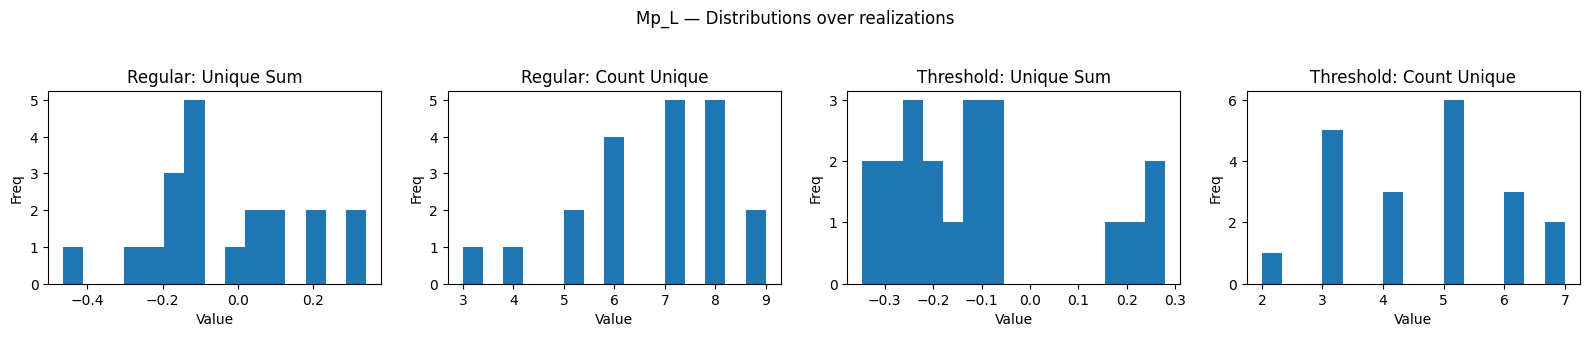

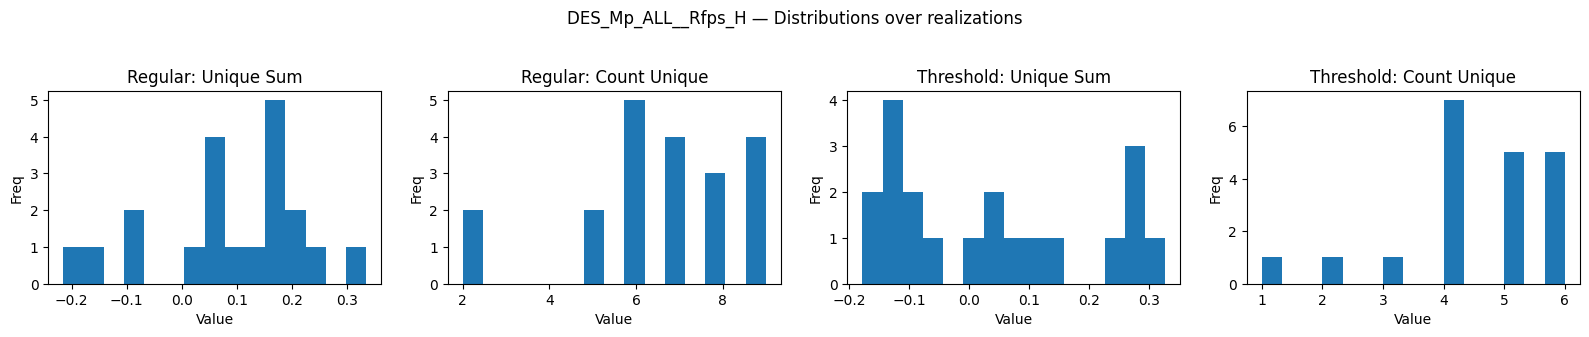

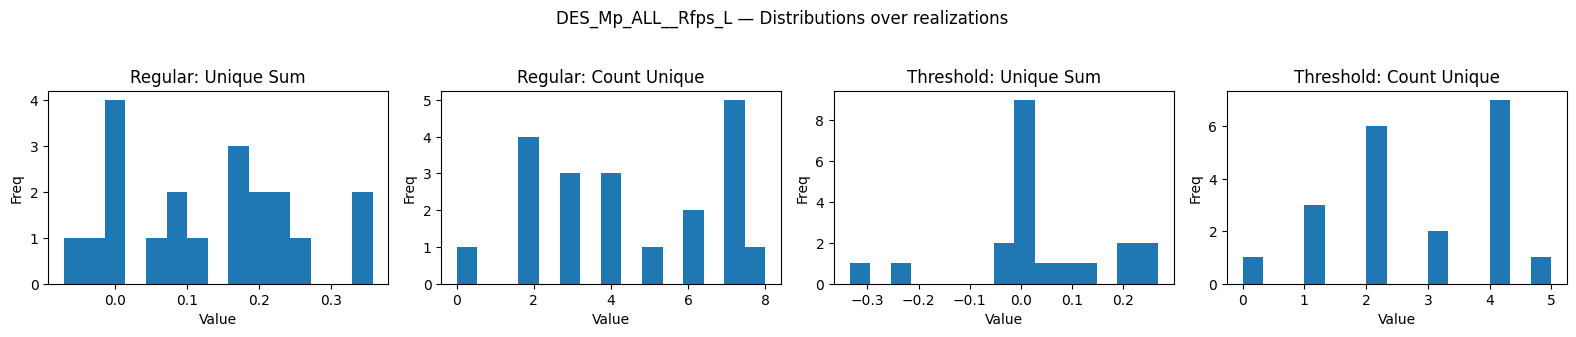

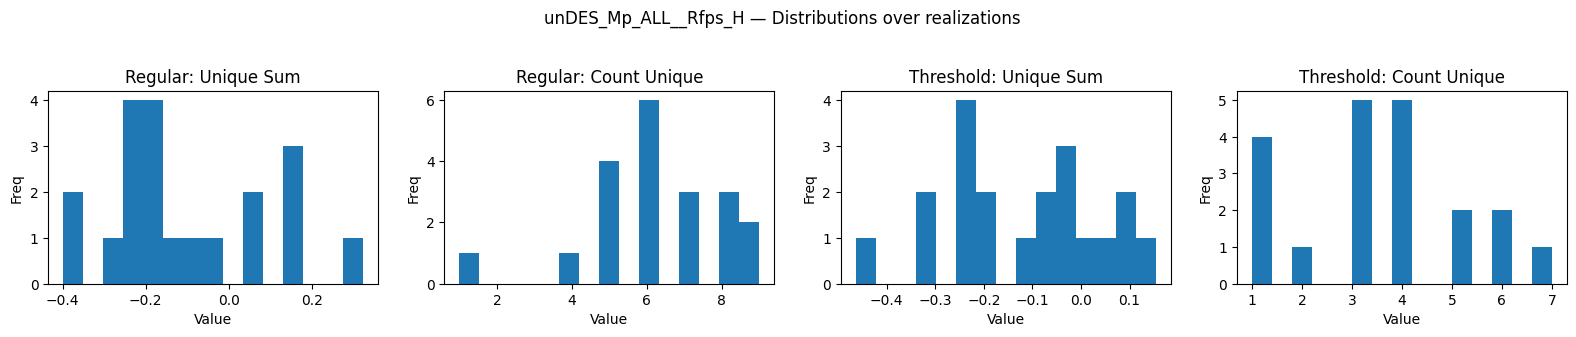

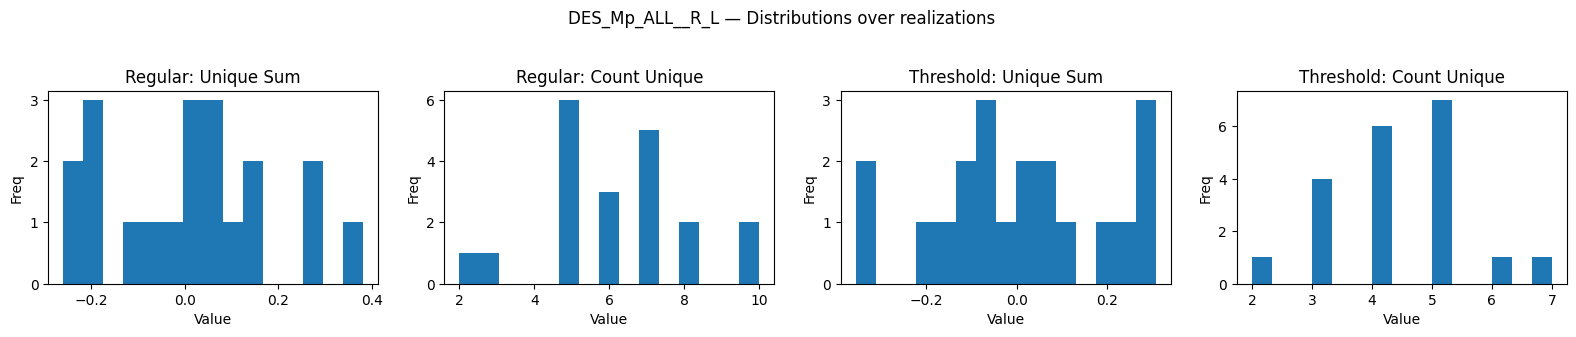

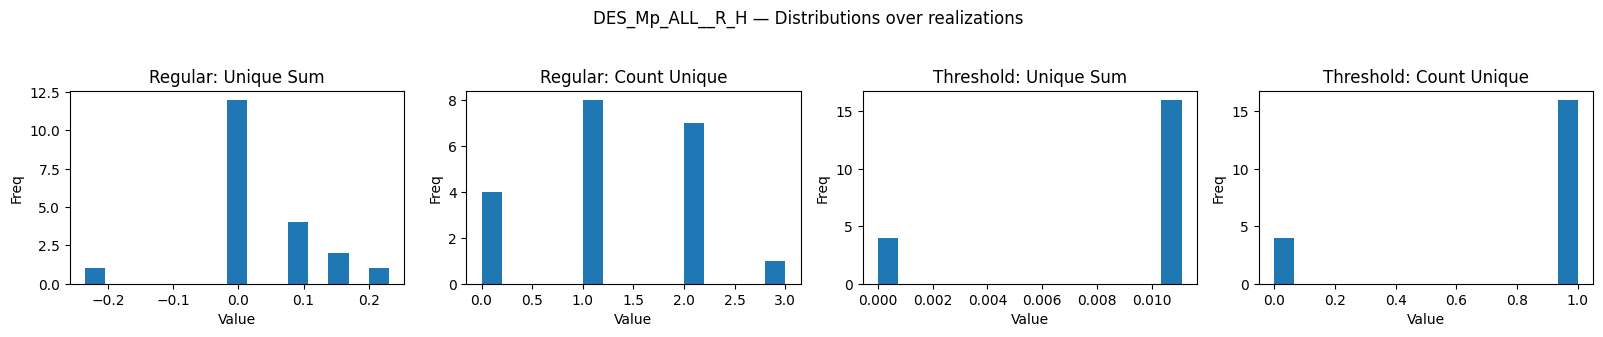

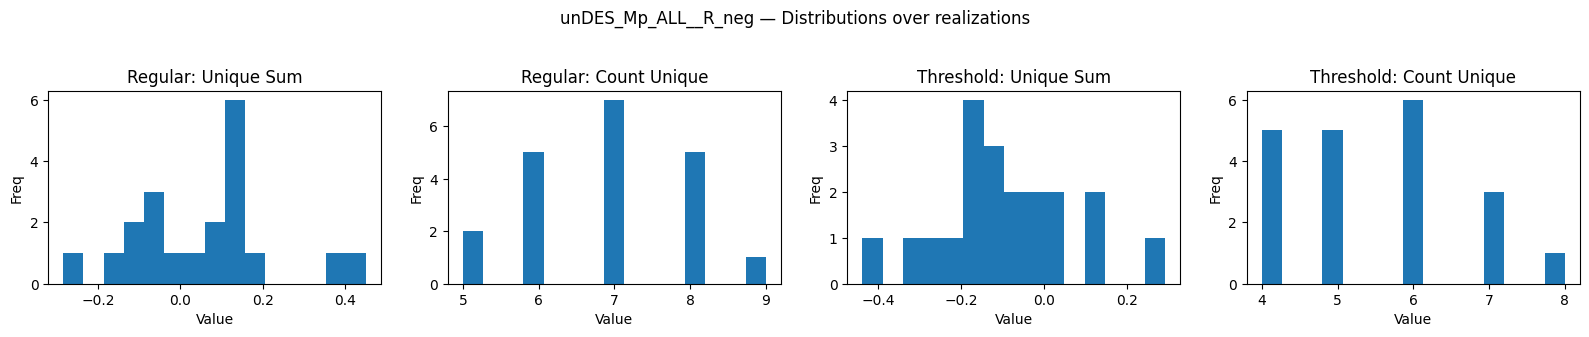

In [33]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [34]:
dd = dict(ALL_models_results_across_realizations)



#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)




    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")



Mp_H
  REG_UNIQUE_SUM:  0.10082419407541443
  REG_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_SHARE:  0.025206048518853608
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_M
  REG_UNIQUE_SUM:  -0.06195285738763934
  REG_NUM_PREDS_UNIQUE:  12
 REG_RETURN_PER_SHARE:  -0.0051627381156366114
  THRESH_UNIQUE_SUM:  -0.06398984044771039
  THR_NUM_PREDS_UNIQUE:  10
 REG_RETURN_PER_SHARE_THRESH:  -0.006398984044771039
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_L
  REG_UNIQUE_SUM:  -0.06195285738763934
  REG_NUM_PREDS_UNIQUE:  12
 REG_RETURN_PER_SHARE:  -0.0051627381156366114
  THRESH_UNIQUE_SUM:  0.1890684771561647
  THR_NUM_PREDS_UNIQUE:  11
 REG_RETURN_PER_SHARE_THRESH:  0.017188043377833154
 --> THRESHOLDING IMPROVED RETURN PER SHARE
DES_Mp_ALL__Rfps_H
  REG_UNIQUE_SUM:  0.13524411454993246
  REG_NUM_PREDS_UNIQUE:  10
 REG_RETURN_PER_SHARE:  0.013524411454993246
  THRESH_UNIQUE_SUM:  0.13524411454993246
  THR_NUM_PREDS_UNIQUE

In [35]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_AND_seeds_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_H__param_map)
    Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_M__param_map)
    Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Sp_L__param_map)

    DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_0fp1tp__param_map)
    DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_1fp1tp__param_map)
    DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map)

    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Sp_H": Sp_H__data_V_T_rawData,
        "Sp_M": Sp_M__data_V_T_rawData,   
        "Sp_L": Sp_L__data_V_T_rawData,

        "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,
        "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__data_V_T_rawData,
        "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData,

        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'DES_TH_Sp_ALL__Hb_0fp1tp', 'DES_TH_Sp_ALL__Hb_1fp1tp', 
    #       'DES_TH_Sp_ALL__Hb_tp_minus_fp', 'DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_H"]["T_set_data"]} ,
        "Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_M"]["T_set_data"]} ,
        "Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Sp_L"]["T_set_data"]} ,
        ###
        "DES_TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,
        "DES_TH_Sp_ALL__Hb_1fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_1fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_1fp1tp"]["T_set_data"]} ,
        "DES_TH_Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]} ,
        ###
        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])



[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

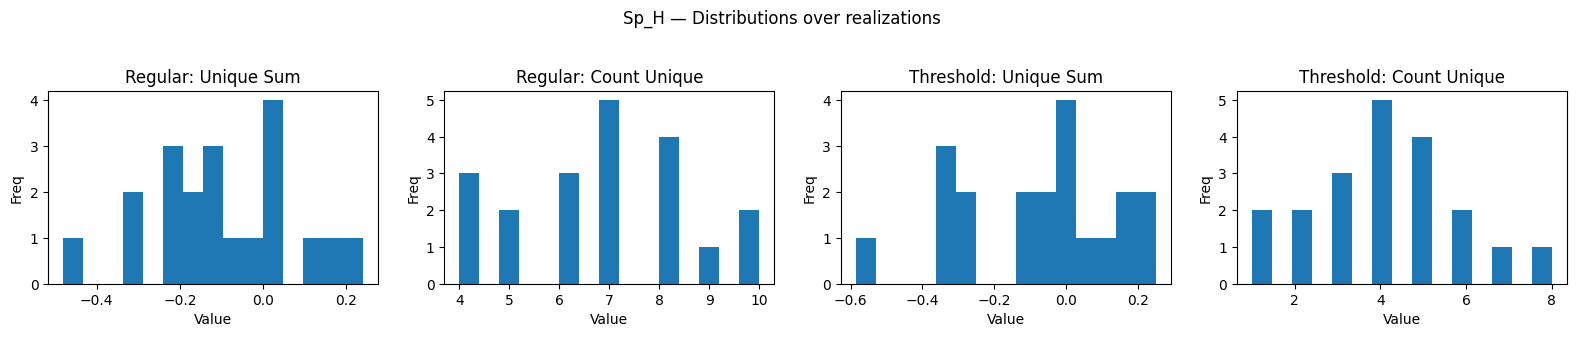

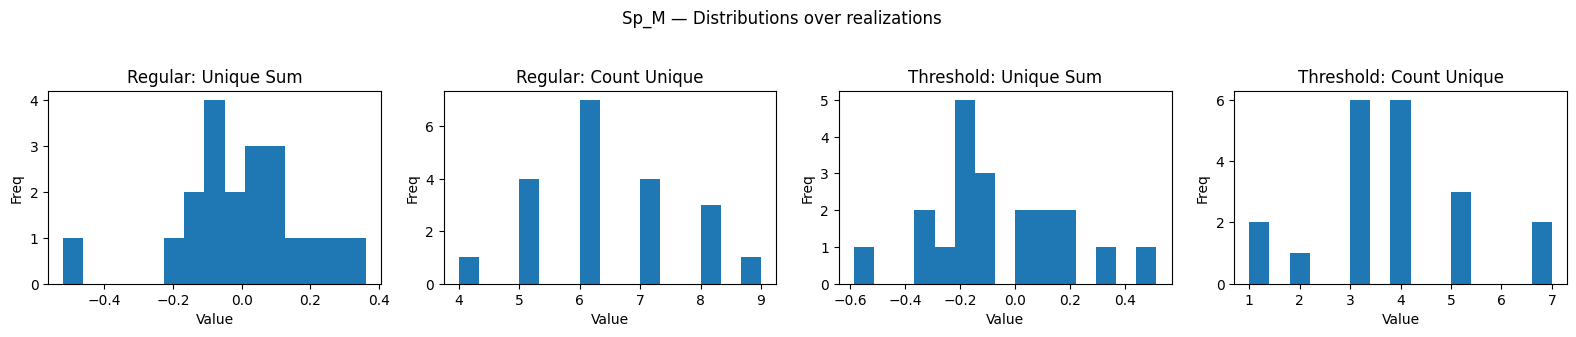

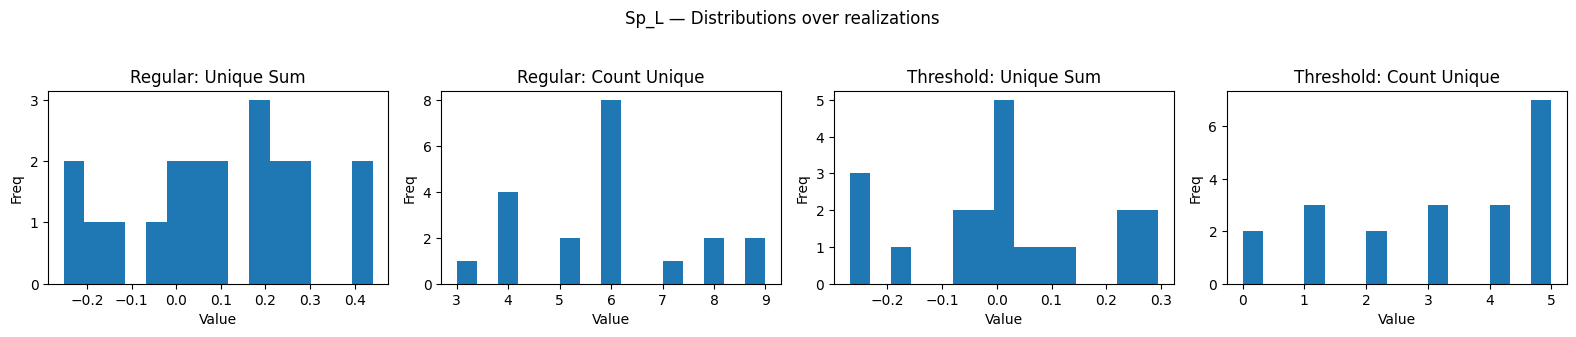

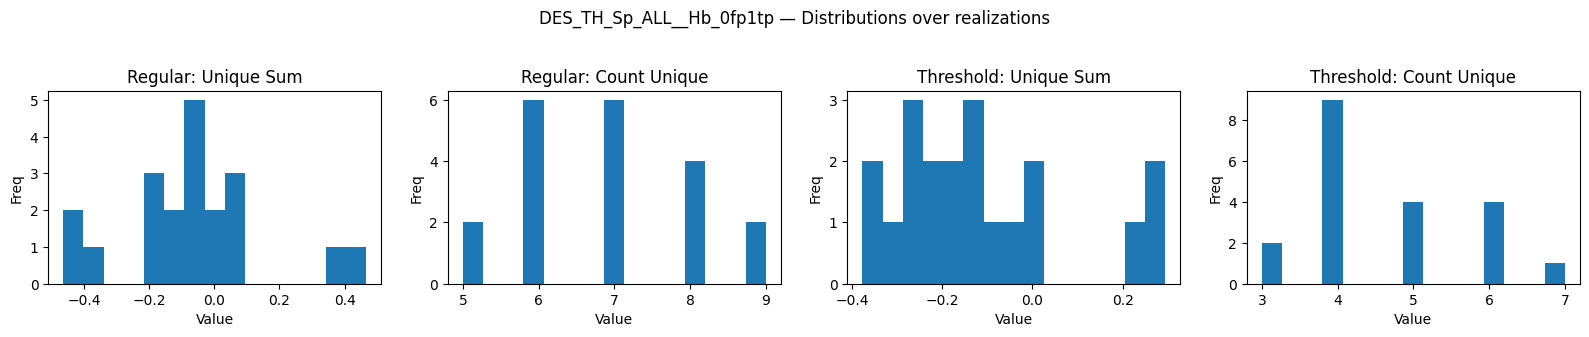

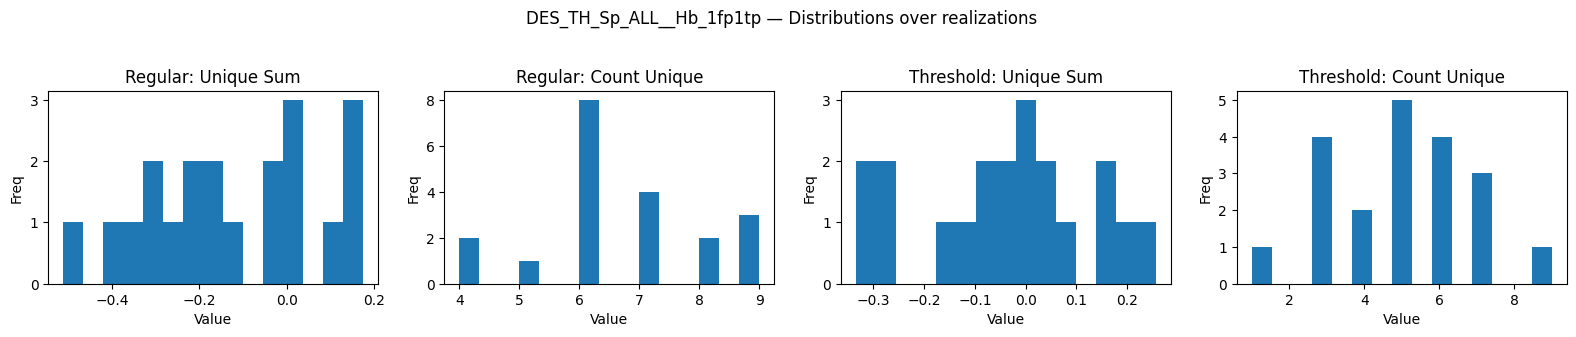

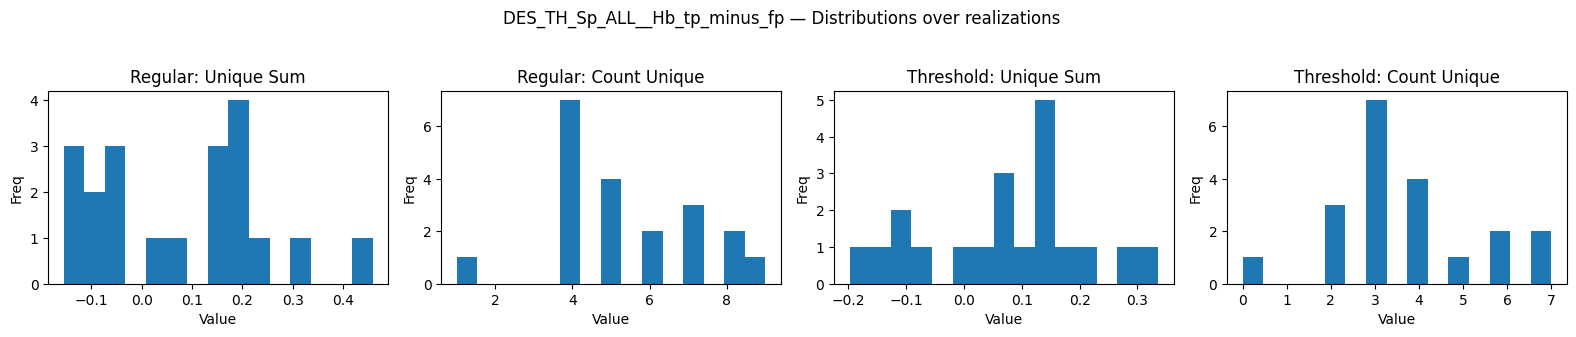

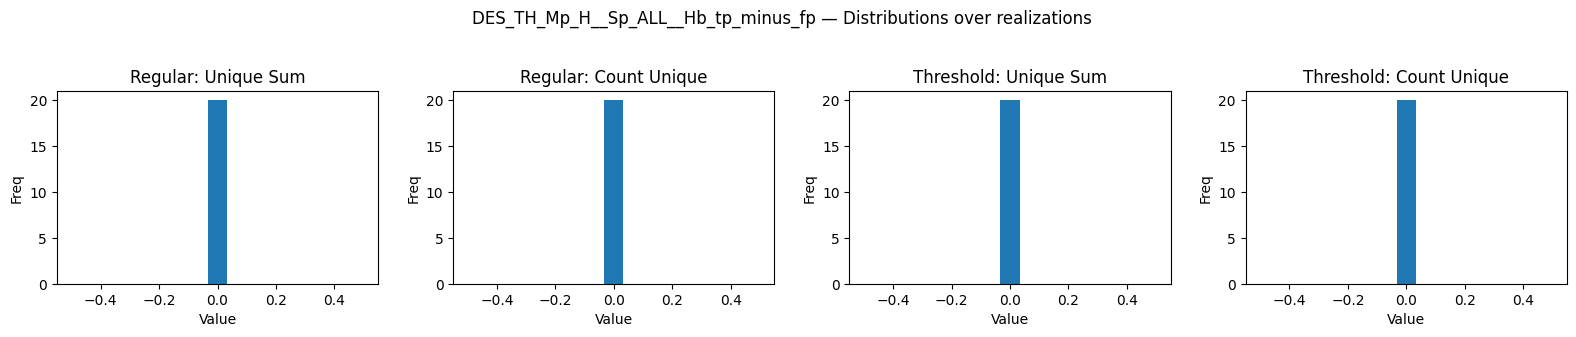

In [36]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_AND_seeds_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [37]:
dd = dict(ALL_models_AND_seeds_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)



    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Sp_H
  REG_UNIQUE_SUM:  -0.06195285738763934
  REG_NUM_PREDS_UNIQUE:  12
 REG_RETURN_PER_SHARE:  -0.0051627381156366114
  THRESH_UNIQUE_SUM:  -0.010165477841478143
  THR_NUM_PREDS_UNIQUE:  11
 REG_RETURN_PER_SHARE_THRESH:  -0.0009241343492252858
 --> THRESHOLDING IMPROVED RETURN PER SHARE
Sp_M
  REG_UNIQUE_SUM:  -0.06195285738763934
  REG_NUM_PREDS_UNIQUE:  12
 REG_RETURN_PER_SHARE:  -0.0051627381156366114
  THRESH_UNIQUE_SUM:  -0.06398984044771039
  THR_NUM_PREDS_UNIQUE:  10
 REG_RETURN_PER_SHARE_THRESH:  -0.006398984044771039
 --> DID NOT IMPROVE RETURN PER SHARE
Sp_L
  REG_UNIQUE_SUM:  0.1890684771561647
  REG_NUM_PREDS_UNIQUE:  11
 REG_RETURN_PER_SHARE:  0.017188043377833154
  THRESH_UNIQUE_SUM:  0.18703149409609365
  THR_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_SHARE_THRESH:  0.020781277121788184
 --> THRESHOLDING IMPROVED RETURN PER SHARE
DES_TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  -0.06195285738763934
  REG_NUM_PREDS_UNIQUE:  12
 REG_RETURN_PER_SHARE:  -0.0051627381156366114
  THRES

In [38]:
    ####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Mp_H__Sp_H__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Mp_H__Sp_M__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Mp_H__Sp_L__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


####                                   Model Selection (SEED + MODEL Fileter)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (55, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, 
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (20, 60) , 
                             "seed_min_TPminusFP_greaterEqual" : 3 , 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,

                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),


                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


models_res_names_dict = {
    "Mp_H__Sp_H": Mp_H__Sp_H__param_map_models,
    "Mp_H__Sp_M": Mp_H__Sp_M__param_map_models,
    "Mp_H__Sp_L": Mp_H__Sp_L__param_map_models,


    "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,

    "Mp_H__DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


# #### collect raw V and T set data for the selected models
# Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


# Mp_H__DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# V_2_MP_H__model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Mp_H__Sp_H__data_V_T_rawData,
#     "Sp_M": Mp_H__Sp_M__data_V_T_rawData,
#     "Sp_L": Mp_H__Sp_L__data_V_T_rawData,

#     "DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

#     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


Models Selected Mp_H__Sp_H: 7
Total seeds selected Mp_H__Sp_H: 347
-----
Models Selected Mp_H__Sp_M: 5
Total seeds selected Mp_H__Sp_M: 55
-----
Models Selected Mp_H__Sp_L: 3
Total seeds selected Mp_H__Sp_L: 13
-----
Models Selected Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp: 2
Total seeds selected Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp: 6
-----
Models Selected Mp_H__DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 3
Total seeds selected Mp_H__DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 14
-----


In [39]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_AND_seeds_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
    Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
    Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

    Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map)

    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Mp_H__Sp_H": Mp_H__Sp_H__data_V_T_rawData,
        "Mp_H__Sp_M": Mp_H__Sp_M__data_V_T_rawData,
        "Mp_H__Sp_L": Mp_H__Sp_L__data_V_T_rawData,

        "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'DES_TH_Sp_ALL__Hb_0fp1tp', 'DES_TH_Sp_ALL__Hb_1fp1tp', 
    #       'DES_TH_Sp_ALL__Hb_tp_minus_fp', 'DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Mp_H__Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["T_set_data"]} ,
        "Mp_H__Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["T_set_data"]} ,
        "Mp_H__Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["T_set_data"]} ,
        ###
        "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,

        ###
        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])



[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

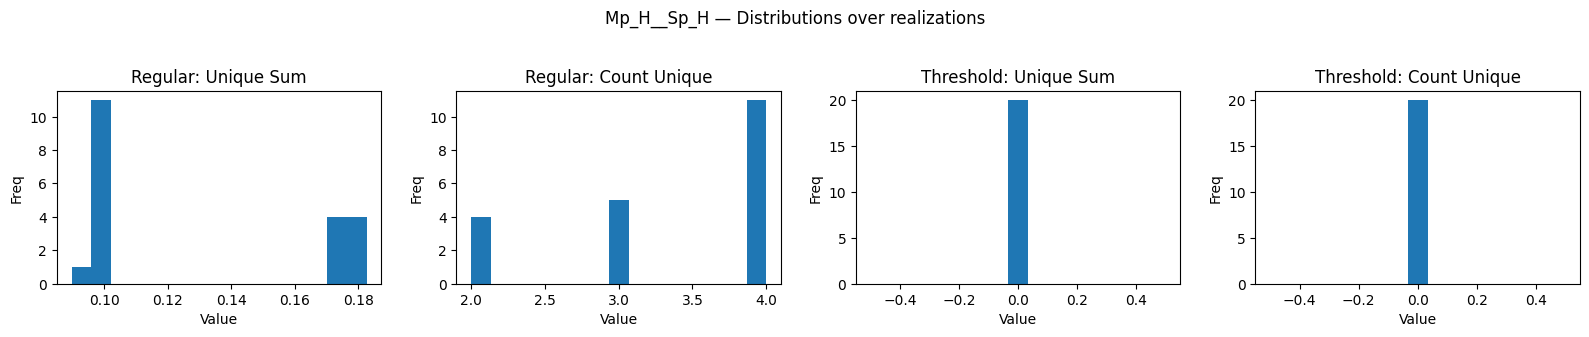

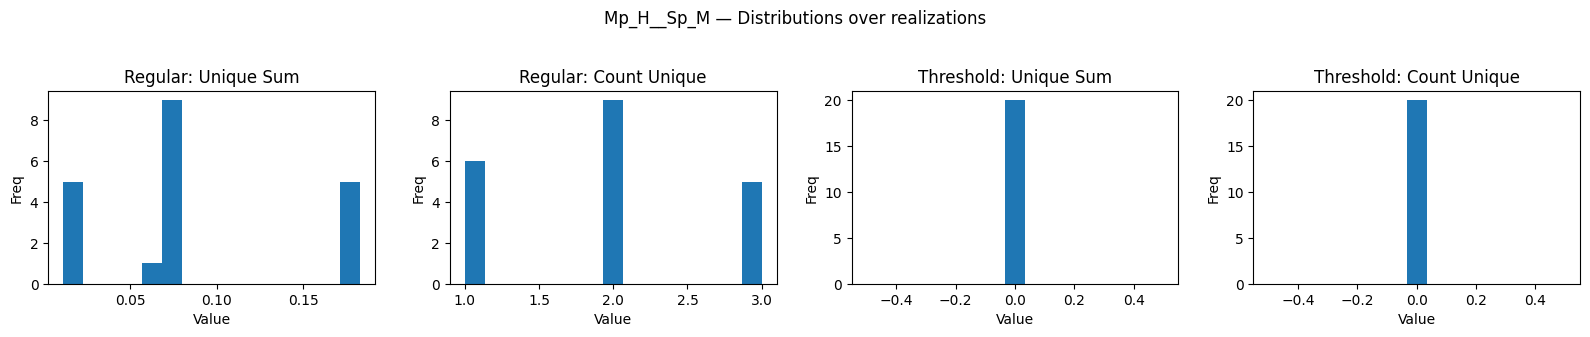

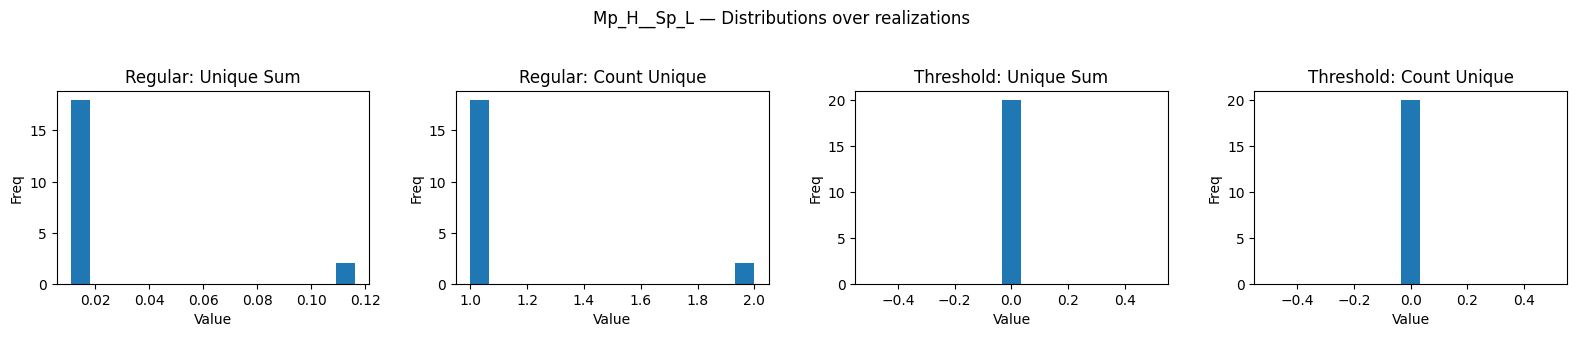

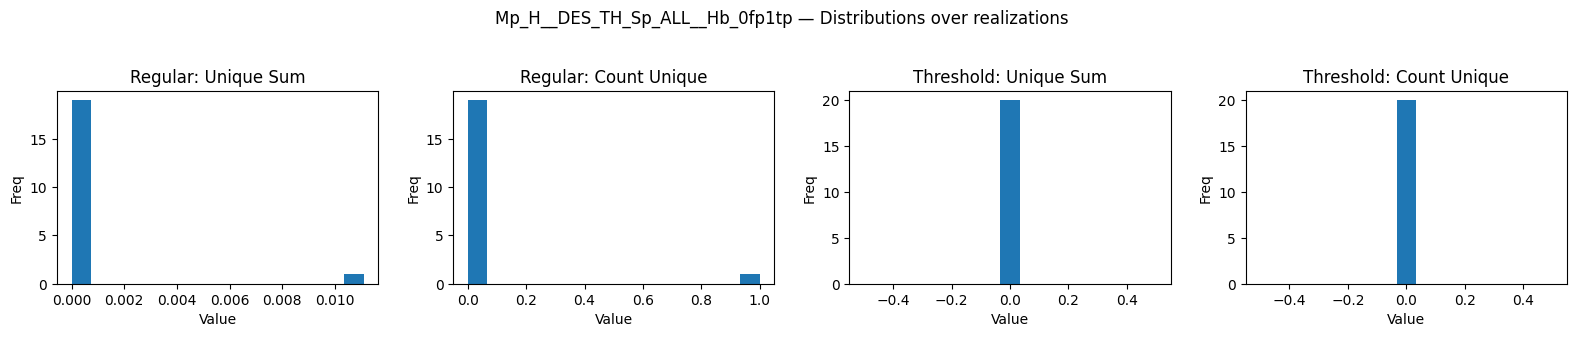

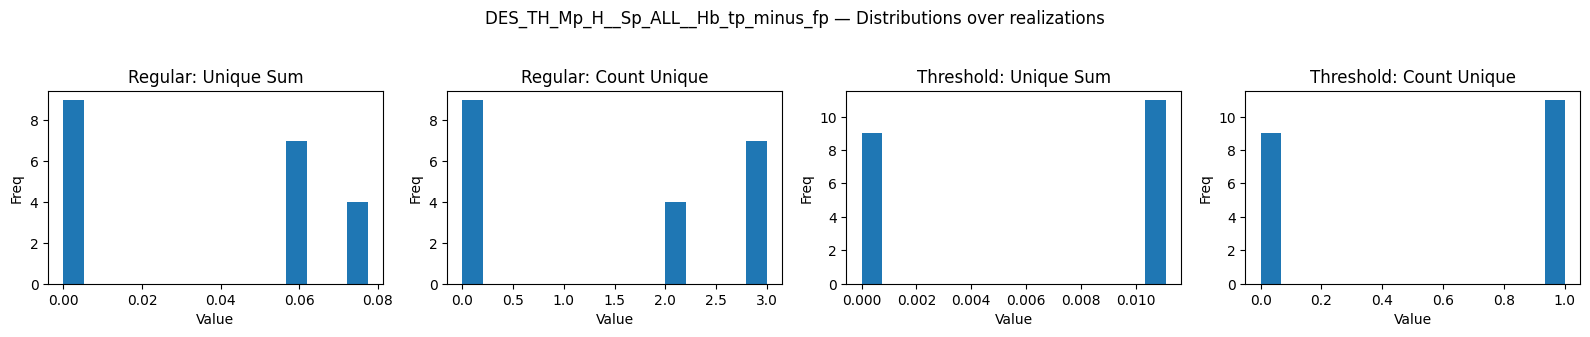

In [40]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_AND_seeds_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [41]:
dd = dict(ALL_models_AND_seeds_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
#     print(set(THRESH_UNIQUE_ALL_flat))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)


    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Mp_H__Sp_H
  REG_UNIQUE_SUM:  0.10082419407541443
  REG_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_SHARE:  0.025206048518853608
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__Sp_M
  REG_UNIQUE_SUM:  0.18266917413437067
  REG_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_SHARE:  0.06088972471145689
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__Sp_L
  REG_UNIQUE_SUM:  0.11636093040677209
  REG_NUM_PREDS_UNIQUE:  2
 REG_RETURN_PER_SHARE:  0.058180465203386045
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  0.011089195704580224
  REG_NUM_PREDS_UNIQUE:  1
 REG_RETURN_PER_SHARE:  0.011089195704580224
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
DES_

In [42]:

####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


#############

DES_Mp_H__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_H__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_H__Rfps_H__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
DES_Mp_H__R_L__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_H__R_H__param_map = {  
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),

                             "min_ratio_difference" : .3, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_H__R_neg__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 100), "seed_recall_range" : (0, 100),
                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################





DES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_H__param_map)
DES_Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_L__param_map)
unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


DES_Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_L__param_map)
DES_Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_H__param_map)
unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 

    "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__param_map_models,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__param_map_models,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__param_map_models,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__param_map_models,

    "DES_Mp_H__R_L": DES_Mp_H__R_L__param_map_models,
    "DES_Mp_H__R_H": DES_Mp_H__R_H__param_map_models,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



#### collect raw V and T set data for the selected models

DES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
#### collect raw V and T set data for the selected models

model_based_selection_maps_raw_V_T_data = {

    "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__data_V_T_rawData,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__data_V_T_rawData,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

    "DES_Mp_H__R_L": DES_Mp_H__R_L__data_V_T_rawData,
    "DES_Mp_H__R_H": DES_Mp_H__R_H__data_V_T_rawData,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
}

import pickle
with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    pickle.dump(model_based_selection_maps_raw_V_T_data, f)


Models Selected DES_Mp_H__Rfps_H: 16
Total seeds selected DES_Mp_H__Rfps_H: 1085
-----
Models Selected DES_Mp_H__Rfps_L: 8
Total seeds selected DES_Mp_H__Rfps_L: 79
-----
Models Selected unDES_Mp_H__Rfps_H: 1
Total seeds selected unDES_Mp_H__Rfps_H: 28
-----
Models Selected DES_Mp_H__R_L: 4
Total seeds selected DES_Mp_H__R_L: 218
-----
Models Selected DES_Mp_H__R_H: 2
Total seeds selected DES_Mp_H__R_H: 140
-----
Models Selected unDES_Mp_H__R_neg: 5
Total seeds selected unDES_Mp_H__R_neg: 328
-----


In [43]:

######################################                                                models selection code 

number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):


    DES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_H__param_map)
    DES_Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_L__param_map)
    unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


    DES_Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_L__param_map)
    DES_Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_H__param_map)
    unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)




    #### collect raw V and T set data for the selected models

    DES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {

        "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__data_V_T_rawData,
        "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__data_V_T_rawData,
        "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

        "DES_Mp_H__R_L": DES_Mp_H__R_L__data_V_T_rawData,
        "DES_Mp_H__R_H": DES_Mp_H__R_H__data_V_T_rawData,
        "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
    }



    models_data_V_T = {

    "DES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_H"]["T_set_data"]} ,
        "DES_Mp_H__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_L"]["T_set_data"]} ,
        "unDES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["T_set_data"]} ,
        ###
        "DES_Mp_H__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_L"]["T_set_data"]} ,
        "DES_Mp_H__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_H"]["T_set_data"]} ,
        "unDES_Mp_H__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))




[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

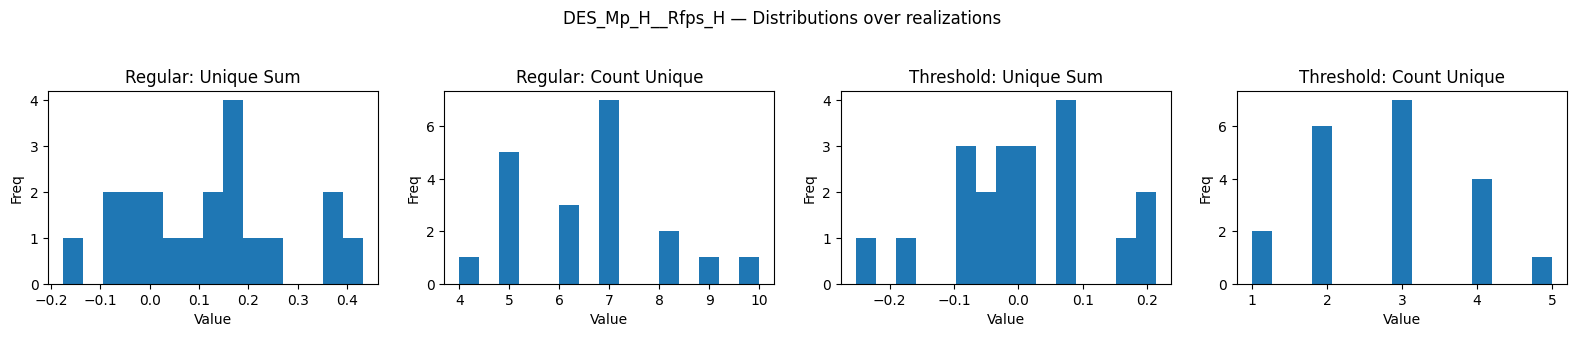

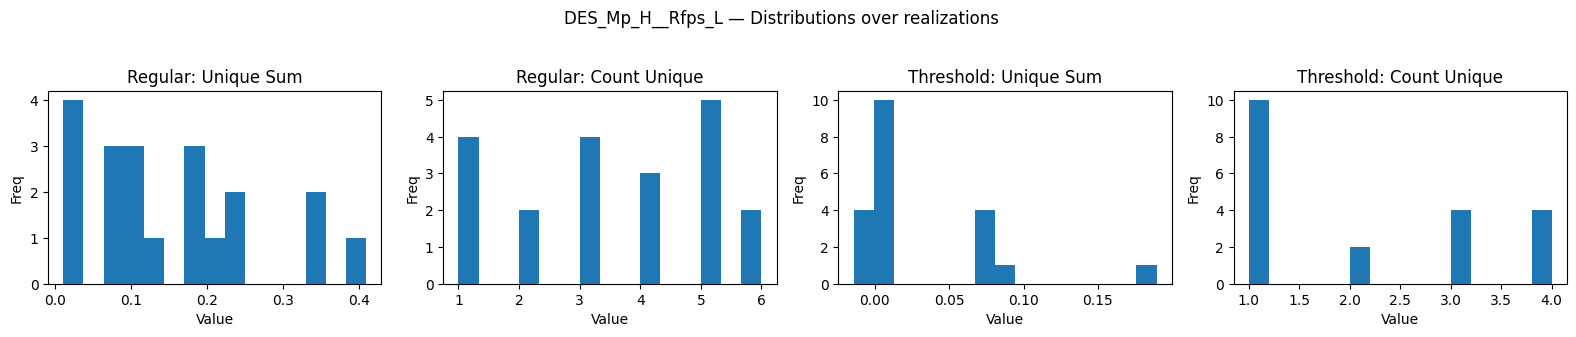

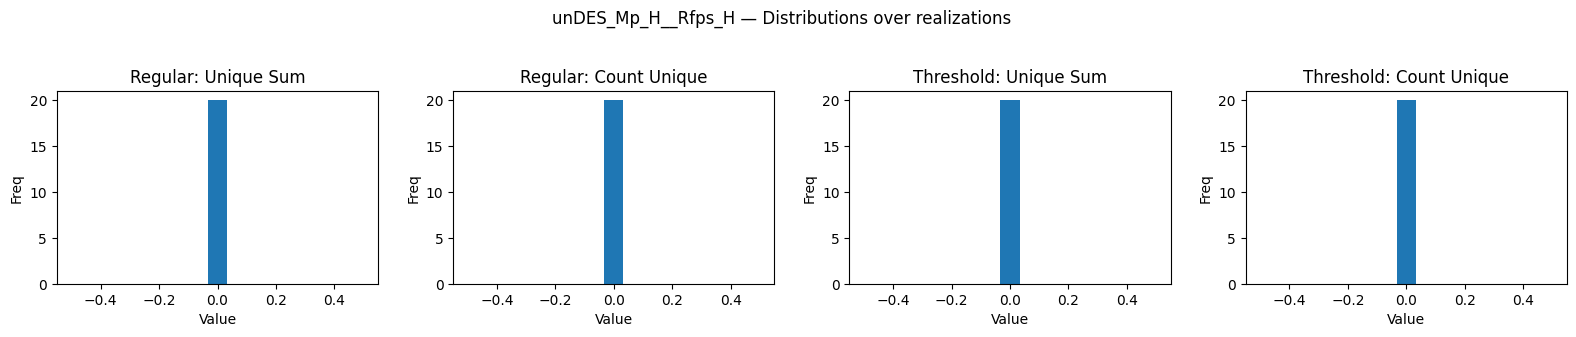

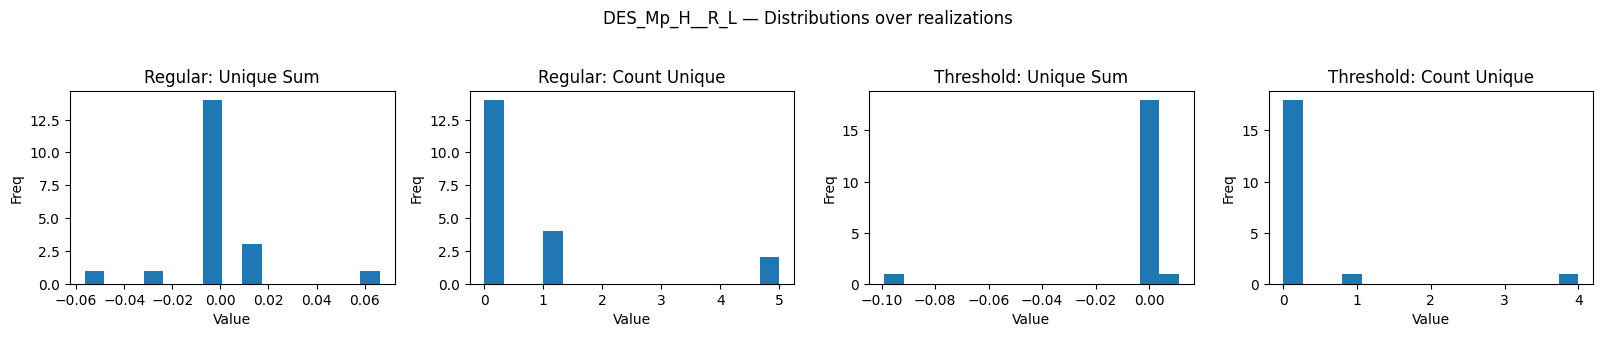

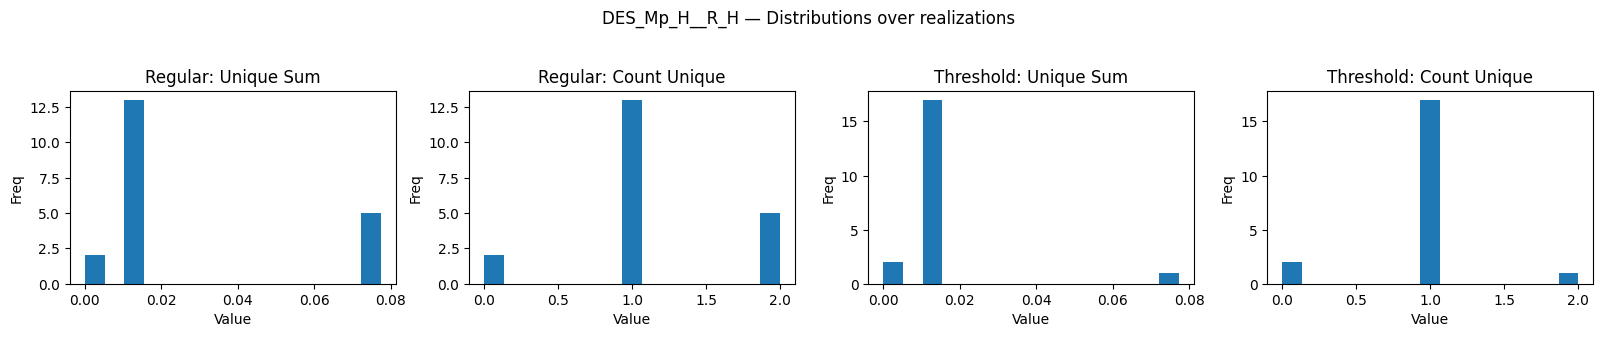

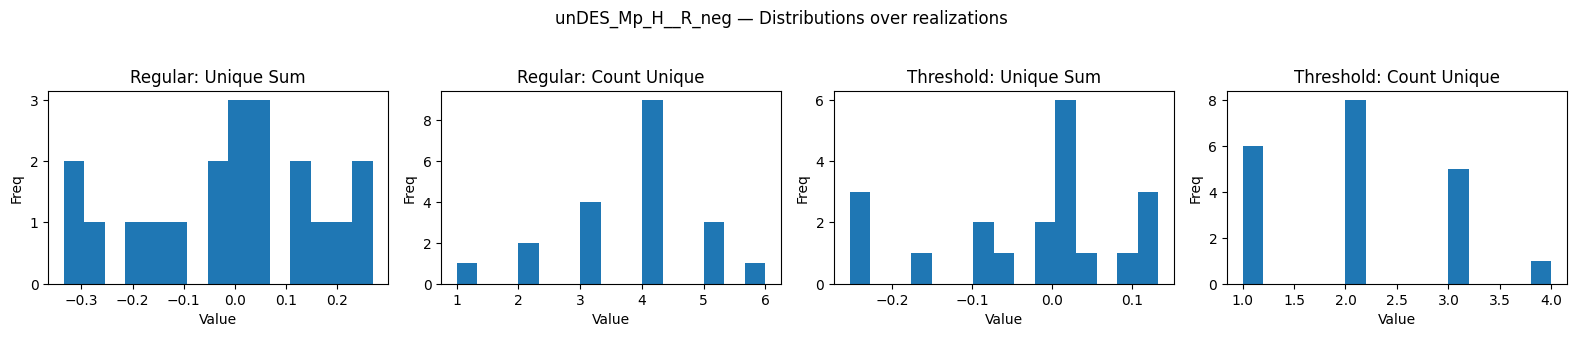

In [44]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [45]:
dd = dict(ALL_models_results_across_realizations)



#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)




    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")



DES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0.13524411454993246
  REG_NUM_PREDS_UNIQUE:  10
 REG_RETURN_PER_SHARE:  0.013524411454993246
  THRESH_UNIQUE_SUM:  0.029972379847740593
  THR_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_SHARE_THRESH:  0.0033302644275267326
 --> DID NOT IMPROVE RETURN PER SHARE
DES_Mp_H__Rfps_L
  REG_UNIQUE_SUM:  0.32764211233507823
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_SHARE:  0.04680601604786832
  THRESH_UNIQUE_SUM:  0.10763956516698359
  THR_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_SHARE_THRESH:  0.02152791303339672
 --> DID NOT IMPROVE RETURN PER SHARE
unDES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0
  REG_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE:  0
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> SAME RETURN PER SHARE
DES_Mp_H__R_L
  REG_UNIQUE_SUM:  0.16360473945285803
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_SHARE:  0.023372105636122575
  THRESH_UNIQUE_SUM:  -0.09915100445355496
  THR_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_SHARE_THRE

In [46]:
#*#*#*#*#   NOTE        LOW RECALL TEST 


####                                   Model Selection (seeds chosen at random)

# params to analyze - mean_precision_range , min_ratio_difference , max_FP_severe_ratio_FPs


#############

DES_Mp_H__Rfps_H__param_map = {   # params to analyze
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.4, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),
                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_H__Rfps_L__param_map = {   # params to analyze
                             "mean_precision_range" : (50, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.2, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                             # params ignored 
                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (1, 40),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


unDES_Mp_H__Rfps_H__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : 0.7, "min_FP_severe_ratio_FPs" : .5,         
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                             "min_ratio_difference" : None, "max_ratio_difference" : None,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

### 
DES_Mp_H__R_L__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),



                             "min_ratio_difference" : 0.1, "max_ratio_difference" : .3,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }


DES_Mp_H__R_H__param_map = {  
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,
                             "mean_recall_up_range" : (0, 40), "seed_recall_range" : (0, 40),



                             "min_ratio_difference" : .3, "max_ratio_difference" : None ,
                             "seed_precision_range" : (0, 100),  "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

unDES_Mp_H__R_neg__param_map = {   
                             "mean_precision_range" : (50, 100),

                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                             "min_ratio_difference" : None, "max_ratio_difference" : 0,
                             "seed_precision_range" : (0, 100), "min_seeds_per_model" : 1,"max_models_to_return" : 70, "seed_min_TPminusFP_greaterEqual" : None,"max_FP_severe_ratio_FPs_andTPs" : None, 
                             "max_seed_severe_FPs_high_bracket" : None,"min_seed_TPs_high_bracket" : None, "random_seed" : None , "min_FP_severe_ratio_FPs_andTPs" : None
                               }

# ###################





DES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_H__param_map)
DES_Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_L__param_map)
unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


DES_Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_L__param_map)
DES_Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_H__param_map)
unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)


models_res_names_dict = { ## print model seleciton info , 

    "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__param_map_models,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__param_map_models,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__param_map_models,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__param_map_models,

    "DES_Mp_H__R_L": DES_Mp_H__R_L__param_map_models,
    "DES_Mp_H__R_H": DES_Mp_H__R_H__param_map_models,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__param_map_models

}   

for k, selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)



#### collect raw V and T set data for the selected models

DES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

DES_Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
DES_Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
#### collect raw V and T set data for the selected models

model_based_selection_maps_raw_V_T_data = {

    "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__data_V_T_rawData,
    "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__data_V_T_rawData,
    "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

    "DES_Mp_H__R_L": DES_Mp_H__R_L__data_V_T_rawData,
    "DES_Mp_H__R_H": DES_Mp_H__R_H__data_V_T_rawData,
    "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
}

import pickle
with open('model_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    pickle.dump(model_based_selection_maps_raw_V_T_data, f)


Models Selected DES_Mp_H__Rfps_H: 11
Total seeds selected DES_Mp_H__Rfps_H: 655
-----
Models Selected DES_Mp_H__Rfps_L: 6
Total seeds selected DES_Mp_H__Rfps_L: 55
-----
Models Selected unDES_Mp_H__Rfps_H: 1
Total seeds selected unDES_Mp_H__Rfps_H: 28
-----
Models Selected DES_Mp_H__R_L: 2
Total seeds selected DES_Mp_H__R_L: 76
-----
Models Selected DES_Mp_H__R_H: 2
Total seeds selected DES_Mp_H__R_H: 98
-----
Models Selected unDES_Mp_H__R_neg: 3
Total seeds selected unDES_Mp_H__R_neg: 137
-----


In [47]:

######################################                                                models selection code 

number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):


    DES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_H__param_map)
    DES_Mp_H__Rfps_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__Rfps_L__param_map)
    unDES_Mp_H__Rfps_H__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__Rfps_H__param_map)


    DES_Mp_H__R_L__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_L__param_map)
    DES_Mp_H__R_H__param_map_models = select_models_by_criteria(results_dist_disc, **DES_Mp_H__R_H__param_map)
    unDES_Mp_H__R_neg__param_map_models = select_models_by_criteria(results_dist_disc, **unDES_Mp_H__R_neg__param_map)




    #### collect raw V and T set data for the selected models

    DES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_H__Rfps_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__Rfps_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__Rfps_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__Rfps_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    DES_Mp_H__R_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    DES_Mp_H__R_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_Mp_H__R_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    unDES_Mp_H__R_neg__data_V_T_rawData = collect_V_T_set_FULLraw_data(unDES_Mp_H__R_neg__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized) 
    #### collect raw V and T set data for the selected models

    model_based_selection_maps_raw_V_T_data = {

        "DES_Mp_H__Rfps_H": DES_Mp_H__Rfps_H__data_V_T_rawData,
        "DES_Mp_H__Rfps_L": DES_Mp_H__Rfps_L__data_V_T_rawData,
        "unDES_Mp_H__Rfps_H": unDES_Mp_H__Rfps_H__data_V_T_rawData,

        "DES_Mp_H__R_L": DES_Mp_H__R_L__data_V_T_rawData,
        "DES_Mp_H__R_H": DES_Mp_H__R_H__data_V_T_rawData,
        "unDES_Mp_H__R_neg": unDES_Mp_H__R_neg__data_V_T_rawData
    }



    models_data_V_T = {

    "DES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_H"]["T_set_data"]} ,
        "DES_Mp_H__Rfps_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__Rfps_L"]["T_set_data"]} ,
        "unDES_Mp_H__Rfps_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__Rfps_H"]["T_set_data"]} ,
        ###
        "DES_Mp_H__R_L" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_L"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_L"]["T_set_data"]} ,
        "DES_Mp_H__R_H" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_H"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["DES_Mp_H__R_H"]["T_set_data"]} ,
        "unDES_Mp_H__R_neg" : {"V_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["V_set_data"] , "T_set_data" : model_based_selection_maps_raw_V_T_data["unDES_Mp_H__R_neg"]["T_set_data"]}
    }


    model_keys = list(models_data_V_T.keys())

    for k in model_keys:
        V_set = models_data_V_T[k]["V_set_data"]
        T_set = models_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])        
        ALL_models_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])
        
        ALL_models_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        

   # print("Total Unique Up Preds Threshold:", len(all_realizations_unique_actuals_ups_threshold_UNIQUE))




[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

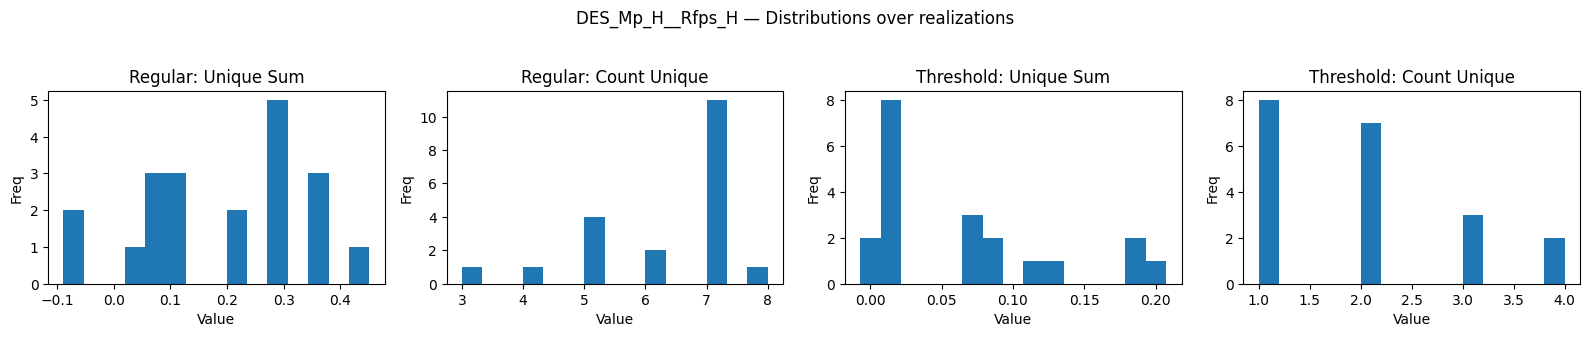

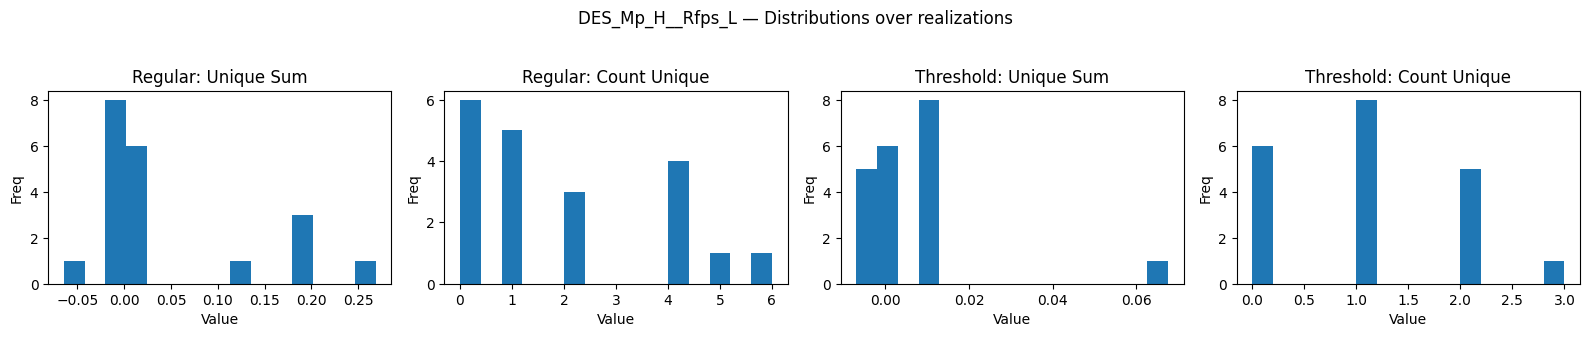

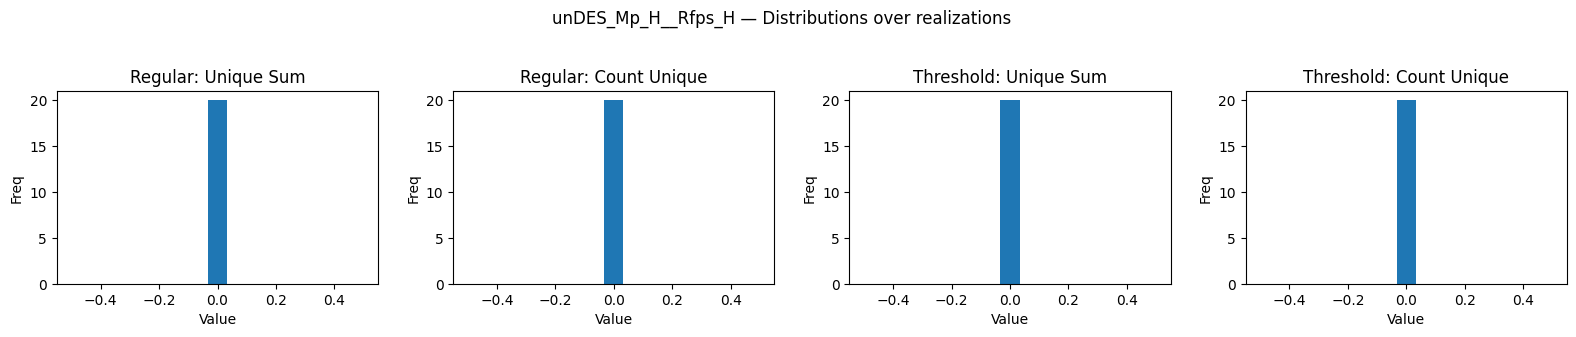

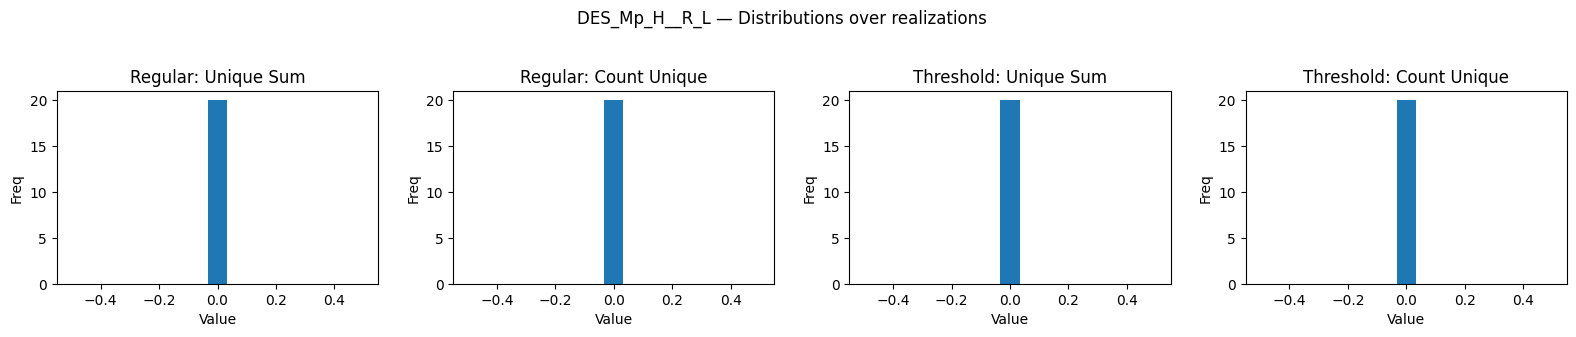

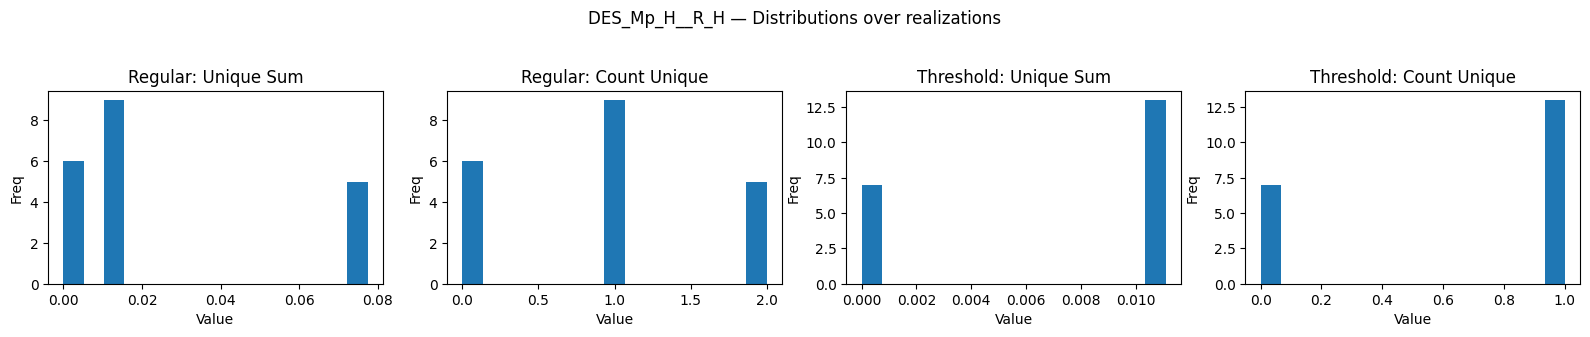

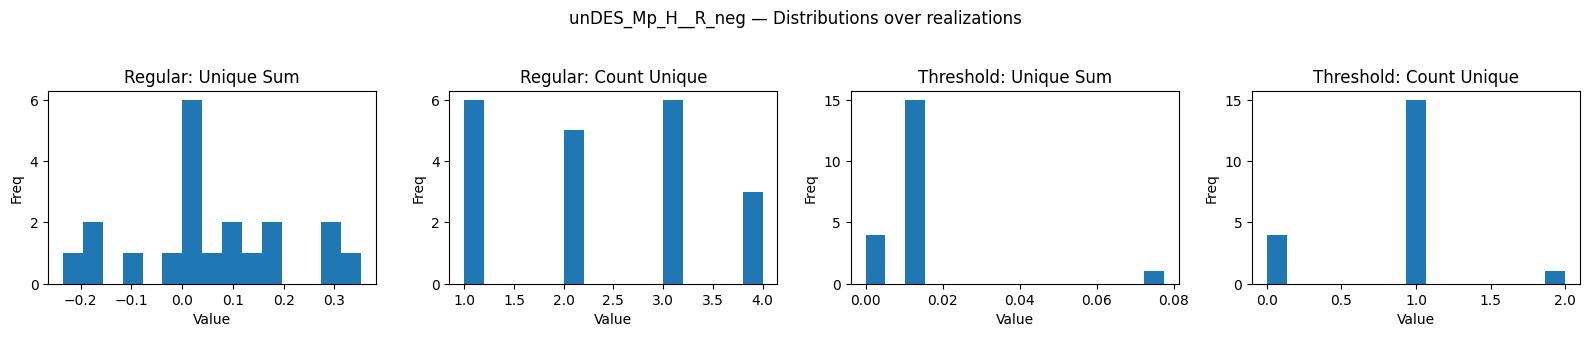

In [48]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [49]:
dd = dict(ALL_models_results_across_realizations)



#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)

    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")



DES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0.18703149409609365
  REG_NUM_PREDS_UNIQUE:  9
 REG_RETURN_PER_SHARE:  0.020781277121788184
  THRESH_UNIQUE_SUM:  0.2557927889535384
  THR_NUM_PREDS_UNIQUE:  5
 REG_RETURN_PER_SHARE_THRESH:  0.05115855779070768
 --> THRESHOLDING IMPROVED RETURN PER SHARE
DES_Mp_H__Rfps_L
  REG_UNIQUE_SUM:  0.16360473945285803
  REG_NUM_PREDS_UNIQUE:  7
 REG_RETURN_PER_SHARE:  0.023372105636122575
  THRESH_UNIQUE_SUM:  0.06758249959258011
  THR_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_SHARE_THRESH:  0.022527499864193373
 --> DID NOT IMPROVE RETURN PER SHARE
unDES_Mp_H__Rfps_H
  REG_UNIQUE_SUM:  0
  REG_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE:  0
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> SAME RETURN PER SHARE
DES_Mp_H__R_L
  REG_UNIQUE_SUM:  0
  REG_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE:  0
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> SAME RETURN PER SHARE
DES_Mp_H__R_H
  REG

In [50]:
#*#*#*#*#    NOTE      LOW RECALL TEST 
    

####                                   Model Selection (SEED filter only) ---- seed filter only to see if the dist discovery inc the prec 

Mp_H__Sp_H__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (75, 100) , 
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),
                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }

Mp_H__Sp_M__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70, "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,"min_ratio_difference" : None, "max_ratio_difference" : None,
                             
                             "seed_precision_range" : (40, 75) , 
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),



                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None ,
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

Mp_H__Sp_L__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,"max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None, "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (1, 40) , 
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),



                             "seed_min_TPminusFP_greaterEqual" : None , "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None , 
                              "min_seeds_per_model" : 1,"max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 
                               }

####

Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map = {   
                             "mean_precision_range" : (70, 100),"max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None, "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, "max_ratio_difference" : None,

                             "seed_precision_range" : (5, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : None , 
                             "max_seed_severe_FPs_high_bracket" : 0 , #**
                             "min_seed_TPs_high_bracket" : 1 , #**
                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),


                              "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70, "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None ,"random_seed" : None 

                               }


####                                   Model Selection (SEED + MODEL Fileter)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map = {   
                             "mean_precision_range" : (55, 100),
                             "max_zero_precision_seeds" : 70,
                             "max_FP_severe_ratio_FPs" : None,
                             "min_FP_severe_ratio_FPs" : None,         
                             "min_ratio_difference" : None, 
                             "max_ratio_difference" : None,

                             "seed_precision_range" : (0, 100) , 
                             "seed_min_TPminusFP_greaterEqual" : 2 ,  ## not enough models if this number is greater than 2 
                             "max_seed_severe_FPs_high_bracket" : None , 
                             "min_seed_TPs_high_bracket" : None,

                             "mean_recall_up_range" : (0, 30), "seed_recall_range" : (0, 30),




                             "min_seeds_per_model" : 1,
                             "max_models_to_return" : 70,
                             "max_FP_severe_ratio_FPs_andTPs" : None, 
                             "min_FP_severe_ratio_FPs_andTPs" : None,

                             "random_seed" : None

                               }


Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map)

DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


models_res_names_dict = {
    "Mp_H__Sp_H": Mp_H__Sp_H__param_map_models,
    "Mp_H__Sp_M": Mp_H__Sp_M__param_map_models,
    "Mp_H__Sp_L": Mp_H__Sp_L__param_map_models,


    "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,

    "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
}


for k , selected_models in models_res_names_dict.items():
   print(f"Models Selected {k}: {len(selected_models)}")
   total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
   print(f"Total seeds selected {k}: {total_seeds}")
   print("-" * 5)


# #### collect raw V and T set data for the selected models
# Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

# Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


# DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
# #### collect raw V and T set data for the selected models

# V_2_MP_H__model_AND_seed_based_selection_maps_raw_V_T_data = {
#     "Sp_H": Mp_H__Sp_H__data_V_T_rawData,
#     "Sp_M": Mp_H__Sp_M__data_V_T_rawData,
#     "Sp_L": Mp_H__Sp_L__data_V_T_rawData,

#     "DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

#     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
# }

# # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
# #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


Models Selected Mp_H__Sp_H: 7
Total seeds selected Mp_H__Sp_H: 336
-----
Models Selected Mp_H__Sp_M: 5
Total seeds selected Mp_H__Sp_M: 48
-----
Models Selected Mp_H__Sp_L: 3
Total seeds selected Mp_H__Sp_L: 13
-----
Models Selected Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp: 1
Total seeds selected Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp: 4
-----
Models Selected DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 3
Total seeds selected DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp: 25
-----


In [51]:


######################################                                                seeds AND models selection code 


number_realizations_outer = 20  # number of realizations to average over for each model

ALL_models_AND_seeds_results_across_realizations = defaultdict(lambda: defaultdict(list))

#### {model_key: {metric: [values across realizations]} , model_key2: {...} , ...}


for i in range(number_realizations_outer):

    Mp_H__Sp_H__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_H__param_map)
    Mp_H__Sp_M__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_M__param_map)
    Mp_H__Sp_L__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__Sp_L__param_map)

    Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models = select_models_by_criteria(results_dist_disc, **Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map)

    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models = select_models_by_criteria(results_dist_disc, **DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map)


    # models_res_names_dict = {
    #     "Sp_H": Sp_H__param_map_models,
    #     "Sp_M": Sp_M__param_map_models,
    #     "Sp_L": Sp_L__param_map_models,


    #     "DES_TH_Sp_ALL__Hb_0fp1tp": DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_1fp1tp": DES_TH_Sp_ALL__Hb_1fp1tp__param_map_models,
    #     "DES_TH_Sp_ALL__Hb_tp_minus_fp": DES_TH_Sp_ALL__Hb_tp_minus_fp__param_map_models,

    #     "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models
    # }


    # for k , selected_models in models_res_names_dict.items():
    #    print(f"Models Selected {k}: {len(selected_models)}")
    #    total_seeds = sum(len(model["selected_seeds"]) for model in selected_models)
    #    print(f"Total seeds selected {k}: {total_seeds}")
    #    print("-" * 5)


    #### collect raw V and T set data for the selected models
    Mp_H__Sp_H__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_H__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_M__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_M__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    Mp_H__Sp_L__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__Sp_L__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)

    Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData = collect_V_T_set_FULLraw_data(Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)


    DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData = collect_V_T_set_FULLraw_data(DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__param_map_models, results_dist_disc, results_dist_disc_Tset_same_seeds_organized)
    #### collect raw V and T set data for the selected models

    model_AND_seed_based_selection_maps_raw_V_T_data = {
        "Mp_H__Sp_H": Mp_H__Sp_H__data_V_T_rawData,
        "Mp_H__Sp_M": Mp_H__Sp_M__data_V_T_rawData,
        "Mp_H__Sp_L": Mp_H__Sp_L__data_V_T_rawData,

        "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp": Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp__data_V_T_rawData,

        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp": DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp__data_V_T_rawData
    }

    # with open('model_AND_seed_based_selection_maps_raw_V_T_data.pkl', 'wb') as f:
    #     pickle.dump(model_AND_seed_based_selection_maps_raw_V_T_data_Seed_and_Model, f)


    # dict_keys(['Sp_H', 'Sp_M', 'Sp_L', 'DES_TH_Sp_ALL__Hb_0fp1tp', 'DES_TH_Sp_ALL__Hb_1fp1tp', 
    #       'DES_TH_Sp_ALL__Hb_tp_minus_fp', 'DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp'])
    models_AND_seeds_data_V_T = {
        "Mp_H__Sp_H" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_H"]["T_set_data"]} ,
        "Mp_H__Sp_M" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_M"]["T_set_data"]} ,
        "Mp_H__Sp_L" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__Sp_L"]["T_set_data"]} ,
        ###
        "Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp"]["T_set_data"]} ,

        ###
        "DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp" : {"V_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["V_set_data"] , "T_set_data" : model_AND_seed_based_selection_maps_raw_V_T_data["DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp"]["T_set_data"]},
    }

    model_keys = list(models_AND_seeds_data_V_T.keys())

    for k in model_keys:
        V_set = models_AND_seeds_data_V_T[k]["V_set_data"]
        T_set = models_AND_seeds_data_V_T[k]["T_set_data"]
        out = process_and_RETURN_analytics(V_set, T_set, do_print=False)
        
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_regular_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["REG_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_regular_UNIQUE"])

        
        
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_ALL"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_UNIQUE_SUM"].append(out["all_realizations_unique_actuals_ups_threshold_UNIQUE_SUM"])
        ALL_models_AND_seeds_results_across_realizations[k]["THR_NUM_PREDS_UNIQUE"].append(out["LEN_all_realizations_unique_actuals_ups_threshold_UNIQUE"])



[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensembles of size 2 for 'T'
[use] pair_2_neg1_1: 7 ensemble

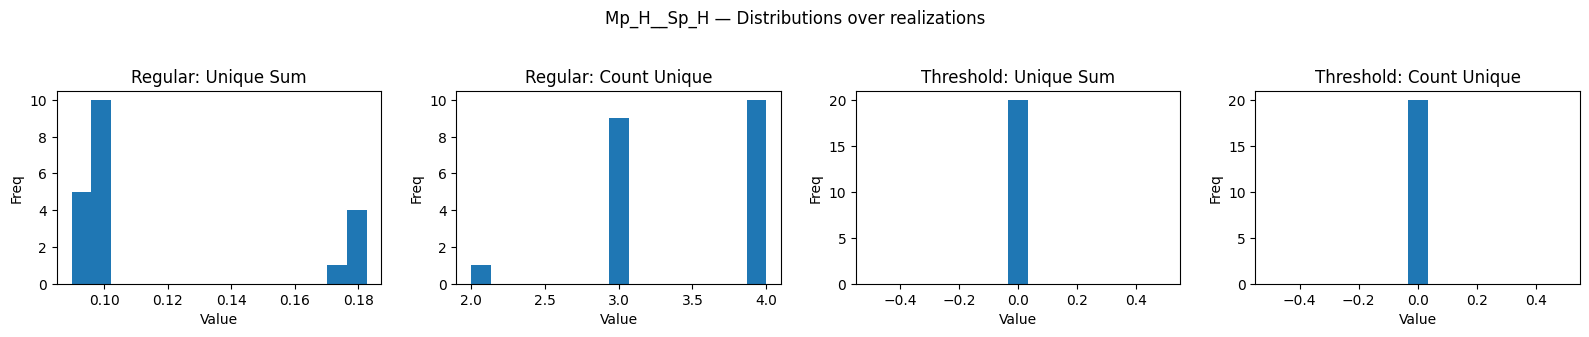

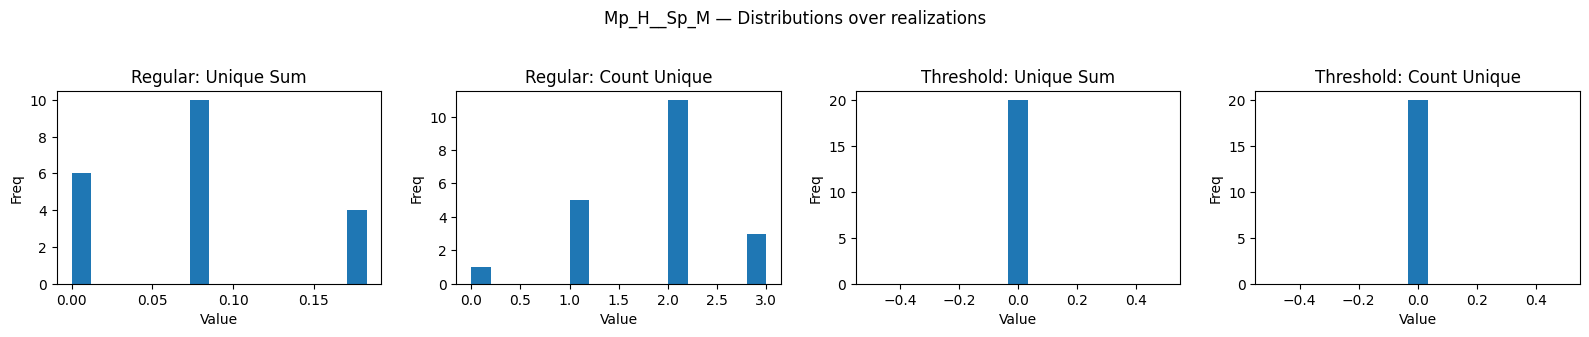

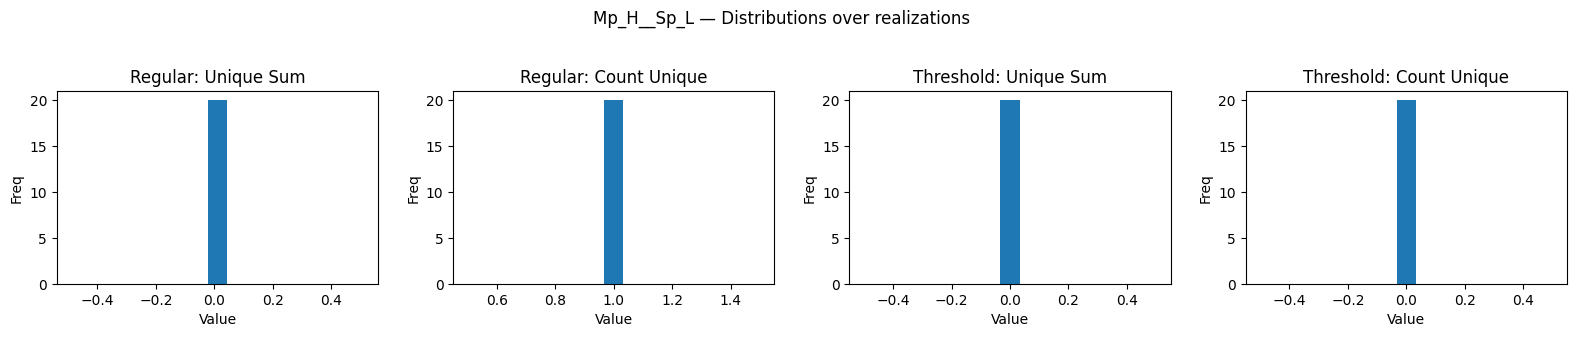

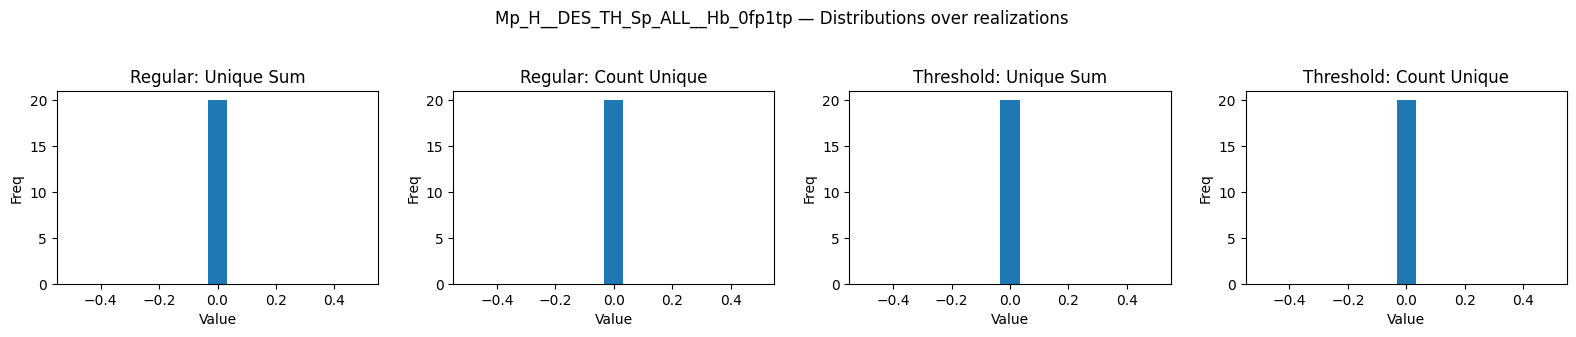

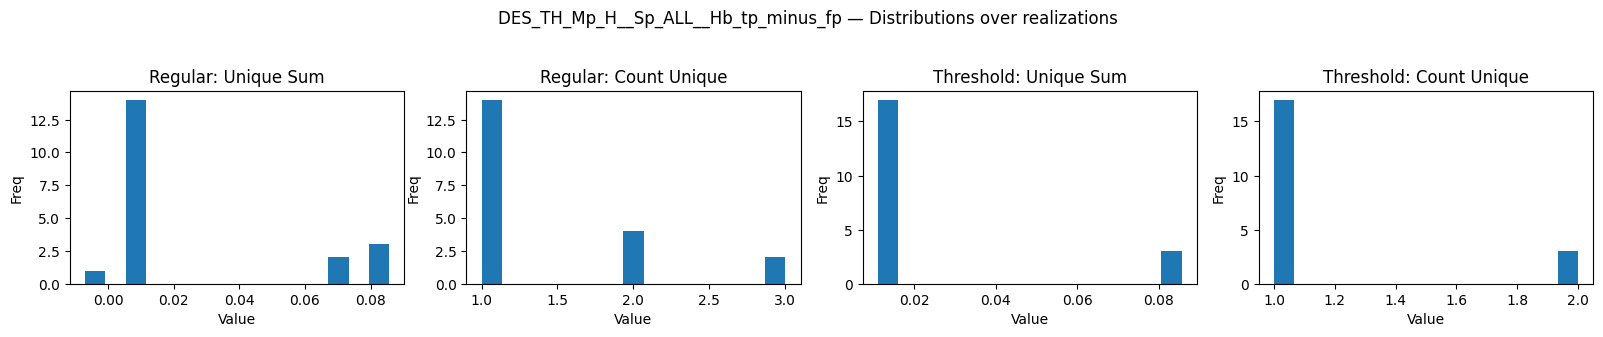

In [52]:
#####                                                models selection code   DIST PLOTS 

import matplotlib.pyplot as plt

METRICS = [
    "REG_UNIQUE_SUM",
    "REG_NUM_PREDS_UNIQUE",
    "THR_UNIQUE_SUM",
    "THR_NUM_PREDS_UNIQUE",
]

TITLES = {
    "REG_UNIQUE_SUM":        "Regular: Unique Sum",
    "REG_NUM_PREDS_UNIQUE":  "Regular: Count Unique",
    "THR_UNIQUE_SUM":        "Threshold: Unique Sum",
    "THR_NUM_PREDS_UNIQUE":  "Threshold: Count Unique",
}

for model_key, metric_dict in ALL_models_AND_seeds_results_across_realizations.items():
    fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
    fig.suptitle(f"{model_key} — Distributions over realizations", fontsize=12)

    for idx, metric in enumerate(METRICS):
        ax = axes[idx]
        vals = metric_dict.get(metric, [])
        if vals:
            ax.hist(vals, bins=15)
            ax.set_xlabel("Value")
            ax.set_ylabel("Freq")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_xticks([]); ax.set_yticks([])

        ax.set_title(TITLES.get(metric, metric))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [53]:
dd = dict(ALL_models_AND_seeds_results_across_realizations)


#### print sum of all vals reg and thresh for unique sum
for k, v in dd.items():
    REG_UNIQUE_ALL_flat = [item for sublist in v["REG_UNIQUE_ALL"] for item in sublist]
    THRESH_UNIQUE_ALL_flat = [item for sublist in v["THR_UNIQUE_ALL"] for item in sublist]

    print(f"{k}")
    
    print(f"  REG_UNIQUE_SUM: " , sum(set(REG_UNIQUE_ALL_flat)))
    print(f"  REG_NUM_PREDS_UNIQUE: " , len(set(REG_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE = sum(set(REG_UNIQUE_ALL_flat)) / len(set(REG_UNIQUE_ALL_flat)) if len(set(REG_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE: " , REG_RETURN_PER_SHARE)

    print(f"  THRESH_UNIQUE_SUM: " , sum(set(THRESH_UNIQUE_ALL_flat)))
#     print(set(THRESH_UNIQUE_ALL_flat))
    print(f"  THR_NUM_PREDS_UNIQUE: " , len(set(THRESH_UNIQUE_ALL_flat)))
    REG_RETURN_PER_SHARE_THRESH = sum(set(THRESH_UNIQUE_ALL_flat)) / len(set(THRESH_UNIQUE_ALL_flat)) if len(set(THRESH_UNIQUE_ALL_flat)) > 0 else 0
    print( " REG_RETURN_PER_SHARE_THRESH: " , REG_RETURN_PER_SHARE_THRESH)


    if (REG_RETURN_PER_SHARE_THRESH == REG_RETURN_PER_SHARE) :
            print(" --> SAME RETURN PER SHARE")
    elif (REG_RETURN_PER_SHARE_THRESH > REG_RETURN_PER_SHARE) :
            print(" --> THRESHOLDING IMPROVED RETURN PER SHARE")

    else:
            print(" --> DID NOT IMPROVE RETURN PER SHARE")

Mp_H__Sp_H
  REG_UNIQUE_SUM:  0.10082419407541443
  REG_NUM_PREDS_UNIQUE:  4
 REG_RETURN_PER_SHARE:  0.025206048518853608
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__Sp_M
  REG_UNIQUE_SUM:  0.18266917413437067
  REG_NUM_PREDS_UNIQUE:  3
 REG_RETURN_PER_SHARE:  0.06088972471145689
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__Sp_L
  REG_UNIQUE_SUM:  0.011089195704580224
  REG_NUM_PREDS_UNIQUE:  1
 REG_RETURN_PER_SHARE:  0.011089195704580224
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> DID NOT IMPROVE RETURN PER SHARE
Mp_H__DES_TH_Sp_ALL__Hb_0fp1tp
  REG_UNIQUE_SUM:  0
  REG_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE:  0
  THRESH_UNIQUE_SUM:  0
  THR_NUM_PREDS_UNIQUE:  0
 REG_RETURN_PER_SHARE_THRESH:  0
 --> SAME RETURN PER SHARE
DES_TH_Mp_H__Sp_ALL__Hb_tp_minus_fp
  REG_UNIQUE_SUM